# A neural network for cracking 4 character captchas with Tensorflow

The purpose of this notebook is to train a neural network to crack simple 4 character captchas.

In [5]:
import matplotlib.pyplot as plt  # for plotting images
import tensorflow as tf   # neural network model
import numpy as np   # for easy use of matrices
import time   # measuring time
from datetime import timedelta   # measuring time
from tqdm import tqdm   # for progress bars
from keras.utils import to_categorical   # for one-hot vectors
import random   # for shuffling the data
import glob   # for loading from a folder
from PIL import Image   # for image objects

Network has 3 convolutional layers with maxpooling at the end of each layer. There is a fully-connected layer after convolutional layers. The output layer is a partially connected layer to fully connected layer. As each character can be a one of digits and English uppercase letters there are 36 possibilites for each character. taking that into consideration I encoded the output layer as 4 one hot vector each with size 36. The partial connection to the output layer is done in the folloing way:
the neurons of fully connected layer are divide into 4 equal groups , then each group is a fully connected layer with one of output vectors,

Filter_sizes are what they say a filter size or kernel size. num_filters are the number of filters/features each convolutional layer extracts. Fc_size is the fully connected layer neuron count.

In [6]:
# Convolutional Layer 1.
filter_size1 = 5         
num_filters1 = 16

# Convolutional Layer 2.
filter_size2 = 5   
num_filters2 = 32 

# Convolutional Layer 3.
filter_size3 = 5 
num_filters3 = 64

# Fully-connected layer.
fc_size = 128*4 

Here is a helper function to read files in the right order (img1, img2, img3, ...., img100, img101, ...).

In [7]:
# custom function to load correctly sorted files
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

In [8]:
# List of all 36 characters
import string
alphabet = [str(x) for x in range(10)] + list(string.ascii_uppercase)

To create one hot vectors I've created a 36 by 4 2d numpy array with keras to_categorical function.

In [9]:
def one_hot_36_keras(y):
    def digitalize(y):
        digitalized = np.empty((0))
        for char in y:
            digit = alphabet.index(char) # get the index of the character
            digitalized = np.append(digitalized,digit) # append the index to numpy array
        return digitalized
    hot = to_categorical(digitalize(y), num_classes = 36) # convert indexes to one-hot vectors
    return hot       

In [14]:
# test if one_hot works
test_array = 'XYZ0'
output = one_hot_36_keras(test_array)
print(output)

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]


Loading part of the dataset to set tenserflow parameters.

In [7]:
%%time
# data.test.labels
# data.test.cls
# data.train.next_batch(train_batch_size)
part = 0
import glob
from PIL import Image
captchalist = sorted(glob.glob(r'D:\Mher\python_notebook\def\captchas\*.jpg'), key = numericalSort)
x_all = np.array([np.array(Image.open(c_name).convert('L')).flatten() for c_name in captchalist[part*1000:1000*(1+part)]])
train_size = int(len(x_all)*0.9)
splited_data = np.split(x_all,[train_size])
x_train = splited_data[0]
x_test = splited_data[1]
labels_all = np.loadtxt(r'D:\Mher\python_notebook\def\captchas\imglabels.txt',dtype = 'str')[part*1000:1000*(1+part)]
splited_labels = np.split(labels_all,[train_size])
y_train = splited_labels[0]
y_test = splited_labels[1]

Wall time: 36.6 s


In [8]:
# make all labels one hot
one_hot_all = np.empty((len(labels_all),4,36),dtype = object)

for idx,array in enumerate(tqdm(labels_all)):

    output = one_hot_36_keras(array)
    one_hot_all[idx] = output
    del output

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 17368.80it/s]


In [9]:
# split one hot
splited_one_hot = np.split(one_hot_all,[train_size])
y_train_one_hot = splited_one_hot[0]
y_test_one_hot = splited_one_hot[1]

In [10]:
# Image heaight and width
img_h = 32
img_w = 64

# As network accepts a 1d array we should flatten the images
img_size_flat = img_h * img_w

# Image shape
img_shape = (img_h, img_w)

# 1 means we will only deal with greyscale images (for RGB it would be 3)
num_channels = 1

# Number of classes
num_classes = 36

In [11]:
# Functions which are used to initialize weights and biases.
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

In [12]:
# Convolutional layer architecture for the neural network

def new_conv_layer(input,              # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter.
                   num_filters,        # Number of filters.
                   use_pooling=True,
                   pad = 'SAME'):  # Use 2x2 max-pooling.

    shape = [filter_size, filter_size, num_input_channels, num_filters]
    weights = new_weights(shape=shape)   # initialize weights
    biases = new_biases(length=num_filters)   # initialize biases
    
    # Load a convolutional layer from TF with strides (1,1)
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding=pad)
    # Add biases
    layer += biases
    
    # Add a max pooling to convolutional layer with kernel size (2,2) and strides (2,2)
    if use_pooling:
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')
        
    # Add Relu activation function
    layer = tf.nn.relu(layer)
    
    return layer, weights

In [13]:
# A function to flatten a layer

def flatten_layer(layer):
    layer_shape = layer.get_shape()
    num_features = layer_shape[1:4].num_elements()
    layer_flat = tf.reshape(layer, [-1, num_features])
    
    return layer_flat, num_features

In [14]:
# Fully Connected layer architecture for the neural network

def new_fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 use_relu=True): # Use Rectified Linear Unit (ReLU)?

    weights = new_weights(shape=[num_inputs, num_outputs])    # initialize weights
    biases = new_biases(length=num_outputs)   # initialize biases
    layer = tf.matmul(input, weights) + biases  #

    if use_relu:
        layer = tf.nn.relu(layer)
    return layer

In [15]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')
x_image = tf.reshape(x, [-1, img_h, img_w, num_channels])
y_true = tf.placeholder(tf.float32, shape=[None,4, num_classes], name='y_true')
y_true_seperate = tf.split(y_true,4,axis = 1)
y_true_cls = tf.argmax(y_true, axis=2)

In [16]:
x

<tf.Tensor 'x:0' shape=(?, 2048) dtype=float32>

In [17]:
y_true

<tf.Tensor 'y_true:0' shape=(?, 4, 36) dtype=float32>

In [18]:
y_true_cls

<tf.Tensor 'ArgMax:0' shape=(?, 4) dtype=int64>

In [19]:
layer_conv1, weights_conv1 = \
    new_conv_layer(input=x_image,
                   num_input_channels=num_channels,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   use_pooling=True)

In [20]:
layer_conv1

<tf.Tensor 'Relu:0' shape=(?, 16, 32, 16) dtype=float32>

In [21]:
layer_conv2, weights_conv2 = \
    new_conv_layer(input=layer_conv1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   use_pooling=True)

In [22]:
layer_conv2

<tf.Tensor 'Relu_1:0' shape=(?, 8, 16, 32) dtype=float32>

In [23]:
layer_conv3, weights_conv3 = \
    new_conv_layer(input=layer_conv2,
                   num_input_channels=num_filters2,
                   filter_size=filter_size3,
                   num_filters=num_filters3,
                   use_pooling=True)

In [24]:
layer_conv3

<tf.Tensor 'Relu_2:0' shape=(?, 4, 8, 64) dtype=float32>

In [25]:
layer_flat, num_features = flatten_layer(layer_conv3)

In [26]:
layer_flat

<tf.Tensor 'Reshape_1:0' shape=(?, 2048) dtype=float32>

In [27]:
layer_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         use_relu=True)

In [28]:
layer_fc1

<tf.Tensor 'Relu_3:0' shape=(?, 512) dtype=float32>

In [29]:
splitted_layer = tf.split(layer_fc1,4,axis = 1)

In [30]:
splitted_layer

[<tf.Tensor 'split_1:0' shape=(?, 128) dtype=float32>,
 <tf.Tensor 'split_1:1' shape=(?, 128) dtype=float32>,
 <tf.Tensor 'split_1:2' shape=(?, 128) dtype=float32>,
 <tf.Tensor 'split_1:3' shape=(?, 128) dtype=float32>]

In [31]:
layer_fc2 = []
for split in splitted_layer:
    l = new_fc_layer(input=split,
                             num_inputs=int(fc_size/4),
                             num_outputs=num_classes,
                             use_relu=False)
    layer_fc2.append(l)

In [32]:
layer_fc2

[<tf.Tensor 'add_4:0' shape=(?, 36) dtype=float32>,
 <tf.Tensor 'add_5:0' shape=(?, 36) dtype=float32>,
 <tf.Tensor 'add_6:0' shape=(?, 36) dtype=float32>,
 <tf.Tensor 'add_7:0' shape=(?, 36) dtype=float32>]

In [33]:
y_pred1 = tf.nn.softmax(layer_fc2[0])
y_pred2 = tf.nn.softmax(layer_fc2[1])
y_pred3 = tf.nn.softmax(layer_fc2[2])
y_pred4 = tf.nn.softmax(layer_fc2[3])
y_pred_cls1 = tf.argmax(y_pred1, axis=1)
y_pred_cls2 = tf.argmax(y_pred2, axis=1)
y_pred_cls3 = tf.argmax(y_pred3, axis=1)
y_pred_cls4 = tf.argmax(y_pred4, axis=1)
y_pred_cls = tf.stack([y_pred_cls1,y_pred_cls2,y_pred_cls3,y_pred_cls4],axis = 1)

In [34]:
y_pred_cls

<tf.Tensor 'stack:0' shape=(?, 4) dtype=int64>

In [35]:
y_pred1

<tf.Tensor 'Softmax:0' shape=(?, 36) dtype=float32>

In [36]:
y_pred_cls1

<tf.Tensor 'ArgMax_1:0' shape=(?,) dtype=int64>

In [37]:
cross_entropy1 = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2[0],labels=y_true_seperate[0])
cross_entropy2 = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2[1],labels=y_true_seperate[1])
cross_entropy3 = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2[2],labels=y_true_seperate[2])
cross_entropy4 = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2[3],labels=y_true_seperate[3])
cost = tf.reduce_mean(cross_entropy1+cross_entropy2+cross_entropy3+cross_entropy4)

In [38]:
cost

<tf.Tensor 'Mean:0' shape=() dtype=float32>

In [39]:
cross_entropy1

<tf.Tensor 'Reshape_4:0' shape=(?,) dtype=float32>

In [40]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

In [41]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

In [42]:
correct_prediction

<tf.Tensor 'Equal:0' shape=(?, 4) dtype=bool>

In [43]:
y_true_cls

<tf.Tensor 'ArgMax:0' shape=(?, 4) dtype=int64>

In [44]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [45]:
accuracy

<tf.Tensor 'Mean_1:0' shape=() dtype=float32>

In [46]:
session = tf.Session()
session.run(tf.global_variables_initializer())

In [47]:
train_batch_size = 100
x_train_batches = np.array(np.array_split(x_train,int(len(x_train)/train_batch_size)))
y_train_batches = np.array(np.array_split(y_train_one_hot,int(len(y_train_one_hot)/train_batch_size)))
data_length = len(y_train_batches)
# Counter for total number of iterations performed so far.
total_iterations = 0
data_part = 0

def optimize(num_iterations):
    global total_iterations,data_part

    start_time = time.time()

    for i in range(total_iterations,
                   total_iterations + num_iterations):
        if i % data_length == 0 and i!=0:
            print('part '+str(data_part+1)+ ' of data was trained')
            data_part +=1
            
        x_batch = x_train_batches[i-data_part*data_length]
        y_true_batch = y_train_batches[i-data_part*data_length]
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}
        session.run(optimizer, feed_dict=feed_dict_train)

        if i % 100 == 0:
            acc = session.run(accuracy, feed_dict=feed_dict_train)
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"
            print(msg.format(i + 1, acc))
            print('Training time since the start : '+str(timedelta(seconds=int(round(time.time()-start_time)))))

    total_iterations += num_iterations
    end_time = time.time()
    time_dif = end_time - start_time
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

In [48]:
# Split the test-set into smaller batches of this size.
test_batch_size = 100

def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    num_test = len(x_test)
    cls_pred = np.zeros(shape=(num_test,4), dtype=np.int)
    i = 0

    while i < num_test:
        j = min(i + test_batch_size, num_test)
        images = x_test[i:j, :]
        labels = y_test_one_hot[i:j, :]
        feed_dict = {x: images,
                     y_true: labels}
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)
        i = j

    cls_true = np.argmax(y_test_one_hot,axis = 2)
    correct = np.all(np.equal(cls_true,cls_pred),axis = 1)
    correct_sum = correct.sum()
    acc = float(correct_sum) / num_test

    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

I have trained the network for 10 epochs and printed progress every 100 iteration (as batch size is 100 progress is printed every 10,000 images).

In [49]:
epochs = 10
captchalist = sorted(glob.glob(r'D:\Mher\python_notebook\def\captchas\*.jpg'), key = numericalSort)
overall_labels = np.loadtxt(r'D:\Mher\python_notebook\def\captchas\imglabels.txt',dtype = 'str')
for j in range(epochs):
    print('EPOCH '+str(j+1)+' has started')
    part = 0
    for i in range(10):
        data_load = time.time()        
        x_all_us = np.array([np.array(Image.open(c_name).convert('L')).flatten() for c_name in captchalist[part*100000:100000*(1+part)]])
        labels_all_us = overall_labels[part*100000:100000*(1+part)]
        c = list(zip(x_all_us, labels_all_us))
        random.shuffle(c)
        x_all, labels_all = zip(*c)    
        train_size = int(len(x_all)*0.9)
        splited_data = np.split(x_all,[train_size])
        x_train = splited_data[0]
        x_test = splited_data[1]

        splited_labels = np.split(labels_all,[train_size])
        y_train = splited_labels[0]
        y_test = splited_labels[1]

        one_hot_all = np.empty((len(labels_all),4,36),dtype = object)

        for idx,array in enumerate(tqdm(labels_all)):

            output = one_hot_36_keras(array)
            one_hot_all[idx] = output
            del output

        splited_one_hot = np.split(one_hot_all,[train_size])
        y_train_one_hot = splited_one_hot[0]
        y_test_one_hot = splited_one_hot[1]
        print('Load time is :'+str(timedelta(seconds=int(round(time.time()-data_load)))))

        x_train_batches = np.array(np.array_split(x_train,int(len(x_train)/train_batch_size)))
        y_train_batches = np.array(np.array_split(y_train_one_hot,int(len(y_train_one_hot)/train_batch_size)))
        data_length = len(y_train_batches)    

        optimize(num_iterations=900)
        print_test_accuracy()
        part+=1
        #del captchalist,x_all,splited_data,x_train,x_test,labels_all,splited_labels,y_train,y_test
        #del one_hot_all,splited_one_hot,y_train_one_hot,y_test_one_hot
        #del x_train_batches,y_train_batches,data_length
        

EPOCH 1 has started


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:05<00:00, 18764.58it/s]


Load time is :0:02:14
Optimization Iteration:      1, Training Accuracy:   4.5%
Training time since the start : 0:00:01
Optimization Iteration:    101, Training Accuracy:   3.2%
Training time since the start : 0:00:26
Optimization Iteration:    201, Training Accuracy:   3.0%
Training time since the start : 0:00:50
Optimization Iteration:    301, Training Accuracy:   4.5%
Training time since the start : 0:01:15
Optimization Iteration:    401, Training Accuracy:   4.0%
Training time since the start : 0:01:39
Optimization Iteration:    501, Training Accuracy:   4.7%
Training time since the start : 0:02:03
Optimization Iteration:    601, Training Accuracy:   5.0%
Training time since the start : 0:02:28
Optimization Iteration:    701, Training Accuracy:   6.5%
Training time since the start : 0:02:52
Optimization Iteration:    801, Training Accuracy:   8.5%
Training time since the start : 0:03:17
Time usage: 0:03:41
Accuracy on Test-Set: 0.0% (0 / 10000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:05<00:00, 18670.10it/s]


Load time is :0:02:35
part 1 of data was trained
Optimization Iteration:    901, Training Accuracy:  11.0%
Training time since the start : 0:00:00
Optimization Iteration:   1001, Training Accuracy:  11.0%
Training time since the start : 0:00:25
Optimization Iteration:   1101, Training Accuracy:  15.3%
Training time since the start : 0:00:49
Optimization Iteration:   1201, Training Accuracy:  19.0%
Training time since the start : 0:01:14
Optimization Iteration:   1301, Training Accuracy:  18.5%
Training time since the start : 0:01:38
Optimization Iteration:   1401, Training Accuracy:  23.3%
Training time since the start : 0:02:03
Optimization Iteration:   1501, Training Accuracy:  25.5%
Training time since the start : 0:02:27
Optimization Iteration:   1601, Training Accuracy:  27.8%
Training time since the start : 0:02:51
Optimization Iteration:   1701, Training Accuracy:  34.5%
Training time since the start : 0:03:16
Time usage: 0:03:40
Accuracy on Test-Set: 1.0% (99 / 10000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:05<00:00, 18687.85it/s]


Load time is :0:02:15
part 2 of data was trained
Optimization Iteration:   1801, Training Accuracy:  36.3%
Training time since the start : 0:00:00
Optimization Iteration:   1901, Training Accuracy:  36.8%
Training time since the start : 0:00:25
Optimization Iteration:   2001, Training Accuracy:  39.0%
Training time since the start : 0:00:49
Optimization Iteration:   2101, Training Accuracy:  40.7%
Training time since the start : 0:01:14
Optimization Iteration:   2201, Training Accuracy:  46.3%
Training time since the start : 0:01:38
Optimization Iteration:   2301, Training Accuracy:  43.8%
Training time since the start : 0:02:02
Optimization Iteration:   2401, Training Accuracy:  45.5%
Training time since the start : 0:02:27
Optimization Iteration:   2501, Training Accuracy:  51.0%
Training time since the start : 0:02:51
Optimization Iteration:   2601, Training Accuracy:  49.5%
Training time since the start : 0:03:16
Time usage: 0:03:40
Accuracy on Test-Set: 9.1% (913 / 10000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:05<00:00, 18622.74it/s]


Load time is :0:02:16
part 3 of data was trained
Optimization Iteration:   2701, Training Accuracy:  52.7%
Training time since the start : 0:00:00
Optimization Iteration:   2801, Training Accuracy:  55.0%
Training time since the start : 0:00:25
Optimization Iteration:   2901, Training Accuracy:  56.2%
Training time since the start : 0:00:49
Optimization Iteration:   3001, Training Accuracy:  63.0%
Training time since the start : 0:01:14
Optimization Iteration:   3101, Training Accuracy:  58.7%
Training time since the start : 0:01:38
Optimization Iteration:   3201, Training Accuracy:  60.3%
Training time since the start : 0:02:02
Optimization Iteration:   3301, Training Accuracy:  64.0%
Training time since the start : 0:02:27
Optimization Iteration:   3401, Training Accuracy:  63.5%
Training time since the start : 0:02:51
Optimization Iteration:   3501, Training Accuracy:  67.0%
Training time since the start : 0:03:16
Time usage: 0:03:40
Accuracy on Test-Set: 21.3% (2129 / 10000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:05<00:00, 18699.41it/s]


Load time is :0:02:17
part 4 of data was trained
Optimization Iteration:   3601, Training Accuracy:  66.5%
Training time since the start : 0:00:00
Optimization Iteration:   3701, Training Accuracy:  69.2%
Training time since the start : 0:00:25
Optimization Iteration:   3801, Training Accuracy:  74.0%
Training time since the start : 0:00:49
Optimization Iteration:   3901, Training Accuracy:  67.0%
Training time since the start : 0:01:14
Optimization Iteration:   4001, Training Accuracy:  72.0%
Training time since the start : 0:01:38
Optimization Iteration:   4101, Training Accuracy:  72.0%
Training time since the start : 0:02:02
Optimization Iteration:   4201, Training Accuracy:  74.5%
Training time since the start : 0:02:27
Optimization Iteration:   4301, Training Accuracy:  72.5%
Training time since the start : 0:02:51
Optimization Iteration:   4401, Training Accuracy:  76.0%
Training time since the start : 0:03:16
Time usage: 0:03:40
Accuracy on Test-Set: 30.6% (3056 / 10000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:05<00:00, 18624.49it/s]


Load time is :0:02:17
part 5 of data was trained
Optimization Iteration:   4501, Training Accuracy:  74.8%
Training time since the start : 0:00:00
Optimization Iteration:   4601, Training Accuracy:  72.8%
Training time since the start : 0:00:25
Optimization Iteration:   4701, Training Accuracy:  73.8%
Training time since the start : 0:00:49
Optimization Iteration:   4801, Training Accuracy:  73.5%
Training time since the start : 0:01:14
Optimization Iteration:   4901, Training Accuracy:  76.2%
Training time since the start : 0:01:39
Optimization Iteration:   5001, Training Accuracy:  77.5%
Training time since the start : 0:02:03
Optimization Iteration:   5101, Training Accuracy:  72.5%
Training time since the start : 0:02:28
Optimization Iteration:   5201, Training Accuracy:  79.5%
Training time since the start : 0:02:52
Optimization Iteration:   5301, Training Accuracy:  81.2%
Training time since the start : 0:03:17
Time usage: 0:03:41
Accuracy on Test-Set: 39.7% (3974 / 10000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:05<00:00, 18633.30it/s]


Load time is :0:02:14
part 6 of data was trained
Optimization Iteration:   5401, Training Accuracy:  78.8%
Training time since the start : 0:00:00
Optimization Iteration:   5501, Training Accuracy:  80.8%
Training time since the start : 0:00:25
Optimization Iteration:   5601, Training Accuracy:  74.8%
Training time since the start : 0:00:49
Optimization Iteration:   5701, Training Accuracy:  84.0%
Training time since the start : 0:01:14
Optimization Iteration:   5801, Training Accuracy:  78.8%
Training time since the start : 0:01:38
Optimization Iteration:   5901, Training Accuracy:  81.0%
Training time since the start : 0:02:03
Optimization Iteration:   6001, Training Accuracy:  79.3%
Training time since the start : 0:02:27
Optimization Iteration:   6101, Training Accuracy:  80.8%
Training time since the start : 0:02:52
Optimization Iteration:   6201, Training Accuracy:  84.5%
Training time since the start : 0:03:16
Time usage: 0:03:40
Accuracy on Test-Set: 45.5% (4551 / 10000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:05<00:00, 18606.60it/s]


Load time is :0:02:14
part 7 of data was trained
Optimization Iteration:   6301, Training Accuracy:  82.5%
Training time since the start : 0:00:00
Optimization Iteration:   6401, Training Accuracy:  81.7%
Training time since the start : 0:00:25
Optimization Iteration:   6501, Training Accuracy:  83.0%
Training time since the start : 0:00:49
Optimization Iteration:   6601, Training Accuracy:  85.0%
Training time since the start : 0:01:14
Optimization Iteration:   6701, Training Accuracy:  82.2%
Training time since the start : 0:01:38
Optimization Iteration:   6801, Training Accuracy:  86.5%
Training time since the start : 0:02:03
Optimization Iteration:   6901, Training Accuracy:  85.8%
Training time since the start : 0:02:27
Optimization Iteration:   7001, Training Accuracy:  82.2%
Training time since the start : 0:02:52
Optimization Iteration:   7101, Training Accuracy:  85.0%
Training time since the start : 0:03:16
Time usage: 0:03:40
Accuracy on Test-Set: 50.6% (5059 / 10000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:05<00:00, 18777.93it/s]


Load time is :0:02:13
part 8 of data was trained
Optimization Iteration:   7201, Training Accuracy:  84.2%
Training time since the start : 0:00:00
Optimization Iteration:   7301, Training Accuracy:  85.0%
Training time since the start : 0:00:25
Optimization Iteration:   7401, Training Accuracy:  83.2%
Training time since the start : 0:00:49
Optimization Iteration:   7501, Training Accuracy:  84.8%
Training time since the start : 0:01:14
Optimization Iteration:   7601, Training Accuracy:  87.3%
Training time since the start : 0:01:38
Optimization Iteration:   7701, Training Accuracy:  86.3%
Training time since the start : 0:02:02
Optimization Iteration:   7801, Training Accuracy:  88.7%
Training time since the start : 0:02:27
Optimization Iteration:   7901, Training Accuracy:  84.8%
Training time since the start : 0:02:51
Optimization Iteration:   8001, Training Accuracy:  86.3%
Training time since the start : 0:03:16
Time usage: 0:03:40
Accuracy on Test-Set: 56.5% (5654 / 10000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:05<00:00, 18649.72it/s]


Load time is :0:02:15
part 9 of data was trained
Optimization Iteration:   8101, Training Accuracy:  87.5%
Training time since the start : 0:00:00
Optimization Iteration:   8201, Training Accuracy:  83.7%
Training time since the start : 0:00:25
Optimization Iteration:   8301, Training Accuracy:  88.0%
Training time since the start : 0:00:49
Optimization Iteration:   8401, Training Accuracy:  84.5%
Training time since the start : 0:01:14
Optimization Iteration:   8501, Training Accuracy:  85.8%
Training time since the start : 0:01:38
Optimization Iteration:   8601, Training Accuracy:  85.3%
Training time since the start : 0:02:03
Optimization Iteration:   8701, Training Accuracy:  88.0%
Training time since the start : 0:02:27
Optimization Iteration:   8801, Training Accuracy:  88.7%
Training time since the start : 0:02:52
Optimization Iteration:   8901, Training Accuracy:  88.0%
Training time since the start : 0:03:16
Time usage: 0:03:40
Accuracy on Test-Set: 60.7% (6068 / 10000)
EPOCH 

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:05<00:00, 18636.44it/s]


Load time is :0:02:52
part 10 of data was trained
Optimization Iteration:   9001, Training Accuracy:  92.0%
Training time since the start : 0:00:00
Optimization Iteration:   9101, Training Accuracy:  88.5%
Training time since the start : 0:00:25
Optimization Iteration:   9201, Training Accuracy:  85.3%
Training time since the start : 0:00:49
Optimization Iteration:   9301, Training Accuracy:  85.8%
Training time since the start : 0:01:14
Optimization Iteration:   9401, Training Accuracy:  86.0%
Training time since the start : 0:01:38
Optimization Iteration:   9501, Training Accuracy:  88.5%
Training time since the start : 0:02:03
Optimization Iteration:   9601, Training Accuracy:  89.7%
Training time since the start : 0:02:27
Optimization Iteration:   9701, Training Accuracy:  90.0%
Training time since the start : 0:02:51
Optimization Iteration:   9801, Training Accuracy:  90.8%
Training time since the start : 0:03:16
Time usage: 0:03:40
Accuracy on Test-Set: 64.4% (6436 / 10000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:05<00:00, 18754.21it/s]


Load time is :0:02:30
part 11 of data was trained
Optimization Iteration:   9901, Training Accuracy:  91.0%
Training time since the start : 0:00:00
Optimization Iteration:  10001, Training Accuracy:  89.7%
Training time since the start : 0:00:25
Optimization Iteration:  10101, Training Accuracy:  89.5%
Training time since the start : 0:00:49
Optimization Iteration:  10201, Training Accuracy:  88.5%
Training time since the start : 0:01:14
Optimization Iteration:  10301, Training Accuracy:  88.5%
Training time since the start : 0:01:38
Optimization Iteration:  10401, Training Accuracy:  87.5%
Training time since the start : 0:02:03
Optimization Iteration:  10501, Training Accuracy:  90.8%
Training time since the start : 0:02:27
Optimization Iteration:  10601, Training Accuracy:  85.3%
Training time since the start : 0:02:52
Optimization Iteration:  10701, Training Accuracy:  88.2%
Training time since the start : 0:03:17
Time usage: 0:03:41
Accuracy on Test-Set: 66.5% (6655 / 10000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:05<00:00, 18550.91it/s]


Load time is :0:02:14
part 12 of data was trained
Optimization Iteration:  10801, Training Accuracy:  88.2%
Training time since the start : 0:00:00
Optimization Iteration:  10901, Training Accuracy:  89.5%
Training time since the start : 0:00:25
Optimization Iteration:  11001, Training Accuracy:  91.5%
Training time since the start : 0:00:49
Optimization Iteration:  11101, Training Accuracy:  89.2%
Training time since the start : 0:01:14
Optimization Iteration:  11201, Training Accuracy:  90.0%
Training time since the start : 0:01:39
Optimization Iteration:  11301, Training Accuracy:  88.2%
Training time since the start : 0:02:03
Optimization Iteration:  11401, Training Accuracy:  90.5%
Training time since the start : 0:02:28
Optimization Iteration:  11501, Training Accuracy:  88.7%
Training time since the start : 0:02:52
Optimization Iteration:  11601, Training Accuracy:  87.7%
Training time since the start : 0:03:17
Time usage: 0:03:41
Accuracy on Test-Set: 68.8% (6880 / 10000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:05<00:00, 18604.83it/s]


Load time is :0:02:14
part 13 of data was trained
Optimization Iteration:  11701, Training Accuracy:  93.0%
Training time since the start : 0:00:00
Optimization Iteration:  11801, Training Accuracy:  88.2%
Training time since the start : 0:00:25
Optimization Iteration:  11901, Training Accuracy:  86.8%
Training time since the start : 0:00:50
Optimization Iteration:  12001, Training Accuracy:  93.8%
Training time since the start : 0:01:15
Optimization Iteration:  12101, Training Accuracy:  92.0%
Training time since the start : 0:01:39
Optimization Iteration:  12201, Training Accuracy:  93.8%
Training time since the start : 0:02:04
Optimization Iteration:  12301, Training Accuracy:  92.0%
Training time since the start : 0:02:28
Optimization Iteration:  12401, Training Accuracy:  92.0%
Training time since the start : 0:02:53
Optimization Iteration:  12501, Training Accuracy:  88.7%
Training time since the start : 0:03:17
Time usage: 0:03:42
Accuracy on Test-Set: 71.6% (7160 / 10000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:05<00:00, 18788.63it/s]


Load time is :0:02:15
part 14 of data was trained
Optimization Iteration:  12601, Training Accuracy:  91.0%
Training time since the start : 0:00:00
Optimization Iteration:  12701, Training Accuracy:  93.3%
Training time since the start : 0:00:25
Optimization Iteration:  12801, Training Accuracy:  91.3%
Training time since the start : 0:00:50
Optimization Iteration:  12901, Training Accuracy:  91.5%
Training time since the start : 0:01:14
Optimization Iteration:  13001, Training Accuracy:  92.3%
Training time since the start : 0:01:39
Optimization Iteration:  13101, Training Accuracy:  91.5%
Training time since the start : 0:02:03
Optimization Iteration:  13201, Training Accuracy:  90.5%
Training time since the start : 0:02:28
Optimization Iteration:  13301, Training Accuracy:  93.8%
Training time since the start : 0:02:53
Optimization Iteration:  13401, Training Accuracy:  93.0%
Training time since the start : 0:03:17
Time usage: 0:03:41
Accuracy on Test-Set: 72.3% (7233 / 10000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:05<00:00, 18757.66it/s]


Load time is :0:02:14
part 15 of data was trained
Optimization Iteration:  13501, Training Accuracy:  94.5%
Training time since the start : 0:00:00
Optimization Iteration:  13601, Training Accuracy:  90.2%
Training time since the start : 0:00:25
Optimization Iteration:  13701, Training Accuracy:  92.0%
Training time since the start : 0:00:49
Optimization Iteration:  13801, Training Accuracy:  91.0%
Training time since the start : 0:01:14
Optimization Iteration:  13901, Training Accuracy:  92.5%
Training time since the start : 0:01:39
Optimization Iteration:  14001, Training Accuracy:  94.5%
Training time since the start : 0:02:03
Optimization Iteration:  14101, Training Accuracy:  92.0%
Training time since the start : 0:02:28
Optimization Iteration:  14201, Training Accuracy:  89.0%
Training time since the start : 0:02:52
Optimization Iteration:  14301, Training Accuracy:  92.5%
Training time since the start : 0:03:17
Time usage: 0:03:41
Accuracy on Test-Set: 73.2% (7325 / 10000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:05<00:00, 18630.96it/s]


Load time is :0:02:11
part 16 of data was trained
Optimization Iteration:  14401, Training Accuracy:  92.3%
Training time since the start : 0:00:00
Optimization Iteration:  14501, Training Accuracy:  91.5%
Training time since the start : 0:00:25
Optimization Iteration:  14601, Training Accuracy:  89.7%
Training time since the start : 0:00:50
Optimization Iteration:  14701, Training Accuracy:  91.8%
Training time since the start : 0:01:14
Optimization Iteration:  14801, Training Accuracy:  93.8%
Training time since the start : 0:01:39
Optimization Iteration:  14901, Training Accuracy:  93.3%
Training time since the start : 0:02:04
Optimization Iteration:  15001, Training Accuracy:  92.8%
Training time since the start : 0:02:28
Optimization Iteration:  15101, Training Accuracy:  93.0%
Training time since the start : 0:02:53
Optimization Iteration:  15201, Training Accuracy:  91.5%
Training time since the start : 0:03:17
Time usage: 0:03:42
Accuracy on Test-Set: 75.1% (7511 / 10000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:05<00:00, 18012.29it/s]


Load time is :0:02:14
part 17 of data was trained
Optimization Iteration:  15301, Training Accuracy:  91.8%
Training time since the start : 0:00:00
Optimization Iteration:  15401, Training Accuracy:  94.0%
Training time since the start : 0:00:25
Optimization Iteration:  15501, Training Accuracy:  93.3%
Training time since the start : 0:00:50
Optimization Iteration:  15601, Training Accuracy:  93.8%
Training time since the start : 0:01:14
Optimization Iteration:  15701, Training Accuracy:  93.0%
Training time since the start : 0:01:39
Optimization Iteration:  15801, Training Accuracy:  93.0%
Training time since the start : 0:02:04
Optimization Iteration:  15901, Training Accuracy:  93.5%
Training time since the start : 0:02:28
Optimization Iteration:  16001, Training Accuracy:  93.0%
Training time since the start : 0:02:53
Optimization Iteration:  16101, Training Accuracy:  92.8%
Training time since the start : 0:03:18
Time usage: 0:03:42
Accuracy on Test-Set: 76.2% (7617 / 10000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:05<00:00, 18689.79it/s]


Load time is :0:02:12
part 18 of data was trained
Optimization Iteration:  16201, Training Accuracy:  93.3%
Training time since the start : 0:00:00
Optimization Iteration:  16301, Training Accuracy:  92.8%
Training time since the start : 0:00:25
Optimization Iteration:  16401, Training Accuracy:  91.8%
Training time since the start : 0:00:50
Optimization Iteration:  16501, Training Accuracy:  91.5%
Training time since the start : 0:01:14
Optimization Iteration:  16601, Training Accuracy:  95.5%
Training time since the start : 0:01:39
Optimization Iteration:  16701, Training Accuracy:  93.3%
Training time since the start : 0:02:03
Optimization Iteration:  16801, Training Accuracy:  94.7%
Training time since the start : 0:02:28
Optimization Iteration:  16901, Training Accuracy:  94.2%
Training time since the start : 0:02:53
Optimization Iteration:  17001, Training Accuracy:  94.5%
Training time since the start : 0:03:17
Time usage: 0:03:42
Accuracy on Test-Set: 77.5% (7751 / 10000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:05<00:00, 18657.98it/s]


Load time is :0:02:15
part 19 of data was trained
Optimization Iteration:  17101, Training Accuracy:  91.8%
Training time since the start : 0:00:00
Optimization Iteration:  17201, Training Accuracy:  93.3%
Training time since the start : 0:00:25
Optimization Iteration:  17301, Training Accuracy:  94.2%
Training time since the start : 0:00:50
Optimization Iteration:  17401, Training Accuracy:  92.5%
Training time since the start : 0:01:14
Optimization Iteration:  17501, Training Accuracy:  96.0%
Training time since the start : 0:01:39
Optimization Iteration:  17601, Training Accuracy:  95.5%
Training time since the start : 0:02:04
Optimization Iteration:  17701, Training Accuracy:  94.7%
Training time since the start : 0:02:28
Optimization Iteration:  17801, Training Accuracy:  93.8%
Training time since the start : 0:02:53
Optimization Iteration:  17901, Training Accuracy:  93.0%
Training time since the start : 0:03:18
Time usage: 0:03:42
Accuracy on Test-Set: 78.4% (7837 / 10000)
EPOCH

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:05<00:00, 18391.02it/s]


Load time is :0:02:44
part 20 of data was trained
Optimization Iteration:  18001, Training Accuracy:  96.0%
Training time since the start : 0:00:00
Optimization Iteration:  18101, Training Accuracy:  92.3%
Training time since the start : 0:00:25
Optimization Iteration:  18201, Training Accuracy:  96.0%
Training time since the start : 0:00:50
Optimization Iteration:  18301, Training Accuracy:  96.5%
Training time since the start : 0:01:14
Optimization Iteration:  18401, Training Accuracy:  95.0%
Training time since the start : 0:01:39
Optimization Iteration:  18501, Training Accuracy:  95.5%
Training time since the start : 0:02:04
Optimization Iteration:  18601, Training Accuracy:  93.0%
Training time since the start : 0:02:28
Optimization Iteration:  18701, Training Accuracy:  95.5%
Training time since the start : 0:02:53
Optimization Iteration:  18801, Training Accuracy:  94.2%
Training time since the start : 0:03:18
Time usage: 0:03:42
Accuracy on Test-Set: 80.1% (8009 / 10000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:05<00:00, 18721.85it/s]


Load time is :0:02:30
part 21 of data was trained
Optimization Iteration:  18901, Training Accuracy:  94.5%
Training time since the start : 0:00:00
Optimization Iteration:  19001, Training Accuracy:  96.0%
Training time since the start : 0:00:25
Optimization Iteration:  19101, Training Accuracy:  95.0%
Training time since the start : 0:00:50
Optimization Iteration:  19201, Training Accuracy:  92.8%
Training time since the start : 0:01:14
Optimization Iteration:  19301, Training Accuracy:  95.0%
Training time since the start : 0:01:39
Optimization Iteration:  19401, Training Accuracy:  95.7%
Training time since the start : 0:02:04
Optimization Iteration:  19501, Training Accuracy:  93.5%
Training time since the start : 0:02:28
Optimization Iteration:  19601, Training Accuracy:  96.5%
Training time since the start : 0:02:53
Optimization Iteration:  19701, Training Accuracy:  95.5%
Training time since the start : 0:03:18
Time usage: 0:03:43
Accuracy on Test-Set: 80.2% (8023 / 10000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:05<00:00, 18703.79it/s]


Load time is :0:02:12
part 22 of data was trained
Optimization Iteration:  19801, Training Accuracy:  94.5%
Training time since the start : 0:00:00
Optimization Iteration:  19901, Training Accuracy:  97.3%
Training time since the start : 0:00:25
Optimization Iteration:  20001, Training Accuracy:  95.5%
Training time since the start : 0:00:50
Optimization Iteration:  20101, Training Accuracy:  93.8%
Training time since the start : 0:01:14
Optimization Iteration:  20201, Training Accuracy:  93.0%
Training time since the start : 0:01:39
Optimization Iteration:  20301, Training Accuracy:  95.0%
Training time since the start : 0:02:04
Optimization Iteration:  20401, Training Accuracy:  94.2%
Training time since the start : 0:02:28
Optimization Iteration:  20501, Training Accuracy:  94.5%
Training time since the start : 0:02:53
Optimization Iteration:  20601, Training Accuracy:  96.2%
Training time since the start : 0:03:18
Time usage: 0:03:42
Accuracy on Test-Set: 82.2% (8218 / 10000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:05<00:00, 18699.14it/s]


Load time is :0:02:16
part 23 of data was trained
Optimization Iteration:  20701, Training Accuracy:  96.0%
Training time since the start : 0:00:00
Optimization Iteration:  20801, Training Accuracy:  95.2%
Training time since the start : 0:00:25
Optimization Iteration:  20901, Training Accuracy:  96.0%
Training time since the start : 0:00:50
Optimization Iteration:  21001, Training Accuracy:  92.3%
Training time since the start : 0:01:14
Optimization Iteration:  21101, Training Accuracy:  97.3%
Training time since the start : 0:01:39
Optimization Iteration:  21201, Training Accuracy:  95.2%
Training time since the start : 0:02:04
Optimization Iteration:  21301, Training Accuracy:  96.7%
Training time since the start : 0:02:28
Optimization Iteration:  21401, Training Accuracy:  96.0%
Training time since the start : 0:02:53
Optimization Iteration:  21501, Training Accuracy:  95.2%
Training time since the start : 0:03:18
Time usage: 0:03:42
Accuracy on Test-Set: 81.7% (8173 / 10000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:05<00:00, 18775.19it/s]


Load time is :0:02:15
part 24 of data was trained
Optimization Iteration:  21601, Training Accuracy:  96.2%
Training time since the start : 0:00:00
Optimization Iteration:  21701, Training Accuracy:  96.5%
Training time since the start : 0:00:25
Optimization Iteration:  21801, Training Accuracy:  97.0%
Training time since the start : 0:00:50
Optimization Iteration:  21901, Training Accuracy:  93.5%
Training time since the start : 0:01:14
Optimization Iteration:  22001, Training Accuracy:  94.7%
Training time since the start : 0:01:39
Optimization Iteration:  22101, Training Accuracy:  95.2%
Training time since the start : 0:02:04
Optimization Iteration:  22201, Training Accuracy:  94.5%
Training time since the start : 0:02:28
Optimization Iteration:  22301, Training Accuracy:  94.2%
Training time since the start : 0:02:53
Optimization Iteration:  22401, Training Accuracy:  97.0%
Training time since the start : 0:03:18
Time usage: 0:03:42
Accuracy on Test-Set: 83.1% (8312 / 10000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:05<00:00, 18717.73it/s]


Load time is :0:02:13
part 25 of data was trained
Optimization Iteration:  22501, Training Accuracy:  95.5%
Training time since the start : 0:00:00
Optimization Iteration:  22601, Training Accuracy:  91.8%
Training time since the start : 0:00:25
Optimization Iteration:  22701, Training Accuracy:  94.2%
Training time since the start : 0:00:50
Optimization Iteration:  22801, Training Accuracy:  96.2%
Training time since the start : 0:01:14
Optimization Iteration:  22901, Training Accuracy:  95.2%
Training time since the start : 0:01:39
Optimization Iteration:  23001, Training Accuracy:  92.5%
Training time since the start : 0:02:03
Optimization Iteration:  23101, Training Accuracy:  94.5%
Training time since the start : 0:02:28
Optimization Iteration:  23201, Training Accuracy:  95.5%
Training time since the start : 0:02:53
Optimization Iteration:  23301, Training Accuracy:  95.7%
Training time since the start : 0:03:17
Time usage: 0:03:42
Accuracy on Test-Set: 83.2% (8324 / 10000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:05<00:00, 18631.03it/s]


Load time is :0:02:12
part 26 of data was trained
Optimization Iteration:  23401, Training Accuracy:  96.7%
Training time since the start : 0:00:00
Optimization Iteration:  23501, Training Accuracy:  97.0%
Training time since the start : 0:00:25
Optimization Iteration:  23601, Training Accuracy:  96.7%
Training time since the start : 0:00:50
Optimization Iteration:  23701, Training Accuracy:  96.5%
Training time since the start : 0:01:14
Optimization Iteration:  23801, Training Accuracy:  97.0%
Training time since the start : 0:01:39
Optimization Iteration:  23901, Training Accuracy:  95.0%
Training time since the start : 0:02:04
Optimization Iteration:  24001, Training Accuracy:  97.5%
Training time since the start : 0:02:29
Optimization Iteration:  24101, Training Accuracy:  95.5%
Training time since the start : 0:02:53
Optimization Iteration:  24201, Training Accuracy:  98.0%
Training time since the start : 0:03:18
Time usage: 0:03:42
Accuracy on Test-Set: 83.6% (8358 / 10000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:05<00:00, 17849.77it/s]


Load time is :0:02:10
part 27 of data was trained
Optimization Iteration:  24301, Training Accuracy:  94.0%
Training time since the start : 0:00:00
Optimization Iteration:  24401, Training Accuracy:  95.7%
Training time since the start : 0:00:25
Optimization Iteration:  24501, Training Accuracy:  95.7%
Training time since the start : 0:00:50
Optimization Iteration:  24601, Training Accuracy:  95.7%
Training time since the start : 0:01:14
Optimization Iteration:  24701, Training Accuracy:  95.2%
Training time since the start : 0:01:39
Optimization Iteration:  24801, Training Accuracy:  93.5%
Training time since the start : 0:02:04
Optimization Iteration:  24901, Training Accuracy:  96.7%
Training time since the start : 0:02:29
Optimization Iteration:  25001, Training Accuracy:  95.5%
Training time since the start : 0:02:53
Optimization Iteration:  25101, Training Accuracy:  94.0%
Training time since the start : 0:03:18
Time usage: 0:03:42
Accuracy on Test-Set: 84.8% (8480 / 10000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:05<00:00, 18276.55it/s]


Load time is :0:02:10
part 28 of data was trained
Optimization Iteration:  25201, Training Accuracy:  95.5%
Training time since the start : 0:00:00
Optimization Iteration:  25301, Training Accuracy:  96.5%
Training time since the start : 0:00:25
Optimization Iteration:  25401, Training Accuracy:  95.7%
Training time since the start : 0:00:50
Optimization Iteration:  25501, Training Accuracy:  96.2%
Training time since the start : 0:01:14
Optimization Iteration:  25601, Training Accuracy:  99.0%
Training time since the start : 0:01:39
Optimization Iteration:  25701, Training Accuracy:  96.7%
Training time since the start : 0:02:04
Optimization Iteration:  25801, Training Accuracy:  95.0%
Training time since the start : 0:02:28
Optimization Iteration:  25901, Training Accuracy:  95.7%
Training time since the start : 0:02:53
Optimization Iteration:  26001, Training Accuracy:  94.5%
Training time since the start : 0:03:17
Time usage: 0:03:42
Accuracy on Test-Set: 85.4% (8539 / 10000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:05<00:00, 18722.04it/s]


Load time is :0:02:15
part 29 of data was trained
Optimization Iteration:  26101, Training Accuracy:  94.5%
Training time since the start : 0:00:00
Optimization Iteration:  26201, Training Accuracy:  96.7%
Training time since the start : 0:00:25
Optimization Iteration:  26301, Training Accuracy:  95.7%
Training time since the start : 0:00:49
Optimization Iteration:  26401, Training Accuracy:  97.5%
Training time since the start : 0:01:14
Optimization Iteration:  26501, Training Accuracy:  95.0%
Training time since the start : 0:01:39
Optimization Iteration:  26601, Training Accuracy:  95.5%
Training time since the start : 0:02:03
Optimization Iteration:  26701, Training Accuracy:  96.0%
Training time since the start : 0:02:28
Optimization Iteration:  26801, Training Accuracy:  95.7%
Training time since the start : 0:02:52
Optimization Iteration:  26901, Training Accuracy:  94.2%
Training time since the start : 0:03:17
Time usage: 0:03:41
Accuracy on Test-Set: 85.2% (8518 / 10000)
EPOCH

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:05<00:00, 18651.25it/s]


Load time is :0:02:37
part 30 of data was trained
Optimization Iteration:  27001, Training Accuracy:  95.0%
Training time since the start : 0:00:00
Optimization Iteration:  27101, Training Accuracy:  96.2%
Training time since the start : 0:00:25
Optimization Iteration:  27201, Training Accuracy:  96.5%
Training time since the start : 0:00:50
Optimization Iteration:  27301, Training Accuracy:  97.3%
Training time since the start : 0:01:14
Optimization Iteration:  27401, Training Accuracy:  95.2%
Training time since the start : 0:01:39
Optimization Iteration:  27501, Training Accuracy:  94.2%
Training time since the start : 0:02:03
Optimization Iteration:  27601, Training Accuracy:  96.7%
Training time since the start : 0:02:28
Optimization Iteration:  27701, Training Accuracy:  93.3%
Training time since the start : 0:02:53
Optimization Iteration:  27801, Training Accuracy:  97.3%
Training time since the start : 0:03:18
Time usage: 0:03:42
Accuracy on Test-Set: 85.6% (8560 / 10000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:05<00:00, 18657.46it/s]


Load time is :0:02:30
part 31 of data was trained
Optimization Iteration:  27901, Training Accuracy:  94.2%
Training time since the start : 0:00:00
Optimization Iteration:  28001, Training Accuracy:  96.7%
Training time since the start : 0:00:25
Optimization Iteration:  28101, Training Accuracy:  96.7%
Training time since the start : 0:00:50
Optimization Iteration:  28201, Training Accuracy:  96.0%
Training time since the start : 0:01:14
Optimization Iteration:  28301, Training Accuracy:  94.2%
Training time since the start : 0:01:39
Optimization Iteration:  28401, Training Accuracy:  95.7%
Training time since the start : 0:02:03
Optimization Iteration:  28501, Training Accuracy:  97.0%
Training time since the start : 0:02:28
Optimization Iteration:  28601, Training Accuracy:  96.2%
Training time since the start : 0:02:52
Optimization Iteration:  28701, Training Accuracy:  96.0%
Training time since the start : 0:03:17
Time usage: 0:03:41
Accuracy on Test-Set: 85.1% (8513 / 10000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:05<00:00, 18728.59it/s]


Load time is :0:02:13
part 32 of data was trained
Optimization Iteration:  28801, Training Accuracy:  95.0%
Training time since the start : 0:00:00
Optimization Iteration:  28901, Training Accuracy:  97.0%
Training time since the start : 0:00:25
Optimization Iteration:  29001, Training Accuracy:  95.5%
Training time since the start : 0:00:50
Optimization Iteration:  29101, Training Accuracy:  96.5%
Training time since the start : 0:01:14
Optimization Iteration:  29201, Training Accuracy:  95.2%
Training time since the start : 0:01:39
Optimization Iteration:  29301, Training Accuracy:  96.2%
Training time since the start : 0:02:04
Optimization Iteration:  29401, Training Accuracy:  97.5%
Training time since the start : 0:02:28
Optimization Iteration:  29501, Training Accuracy:  96.2%
Training time since the start : 0:02:53
Optimization Iteration:  29601, Training Accuracy:  98.0%
Training time since the start : 0:03:18
Time usage: 0:03:42
Accuracy on Test-Set: 85.2% (8518 / 10000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:05<00:00, 18760.11it/s]


Load time is :0:02:16
part 33 of data was trained
Optimization Iteration:  29701, Training Accuracy:  96.5%
Training time since the start : 0:00:00
Optimization Iteration:  29801, Training Accuracy:  97.0%
Training time since the start : 0:00:25
Optimization Iteration:  29901, Training Accuracy:  97.5%
Training time since the start : 0:00:50
Optimization Iteration:  30001, Training Accuracy:  96.7%
Training time since the start : 0:01:14
Optimization Iteration:  30101, Training Accuracy:  93.8%
Training time since the start : 0:01:39
Optimization Iteration:  30201, Training Accuracy:  96.5%
Training time since the start : 0:02:04
Optimization Iteration:  30301, Training Accuracy:  95.7%
Training time since the start : 0:02:28
Optimization Iteration:  30401, Training Accuracy:  96.5%
Training time since the start : 0:02:53
Optimization Iteration:  30501, Training Accuracy:  94.5%
Training time since the start : 0:03:17
Time usage: 0:03:42
Accuracy on Test-Set: 87.1% (8711 / 10000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:05<00:00, 18667.99it/s]


Load time is :0:02:13
part 34 of data was trained
Optimization Iteration:  30601, Training Accuracy:  95.2%
Training time since the start : 0:00:00
Optimization Iteration:  30701, Training Accuracy:  96.2%
Training time since the start : 0:00:25
Optimization Iteration:  30801, Training Accuracy:  98.0%
Training time since the start : 0:00:50
Optimization Iteration:  30901, Training Accuracy:  94.7%
Training time since the start : 0:01:14
Optimization Iteration:  31001, Training Accuracy:  96.5%
Training time since the start : 0:01:39
Optimization Iteration:  31101, Training Accuracy:  94.7%
Training time since the start : 0:02:04
Optimization Iteration:  31201, Training Accuracy:  98.3%
Training time since the start : 0:02:29
Optimization Iteration:  31301, Training Accuracy:  97.0%
Training time since the start : 0:02:53
Optimization Iteration:  31401, Training Accuracy:  97.3%
Training time since the start : 0:03:18
Time usage: 0:03:42
Accuracy on Test-Set: 86.5% (8647 / 10000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:05<00:00, 18659.61it/s]


Load time is :0:02:13
part 35 of data was trained
Optimization Iteration:  31501, Training Accuracy:  95.7%
Training time since the start : 0:00:00
Optimization Iteration:  31601, Training Accuracy:  98.0%
Training time since the start : 0:00:25
Optimization Iteration:  31701, Training Accuracy:  96.2%
Training time since the start : 0:00:50
Optimization Iteration:  31801, Training Accuracy:  95.7%
Training time since the start : 0:01:14
Optimization Iteration:  31901, Training Accuracy:  97.0%
Training time since the start : 0:01:40
Optimization Iteration:  32001, Training Accuracy:  98.3%
Training time since the start : 0:02:04
Optimization Iteration:  32101, Training Accuracy:  95.0%
Training time since the start : 0:02:29
Optimization Iteration:  32201, Training Accuracy:  95.5%
Training time since the start : 0:02:54
Optimization Iteration:  32301, Training Accuracy:  97.3%
Training time since the start : 0:03:18
Time usage: 0:03:43
Accuracy on Test-Set: 87.9% (8790 / 10000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:05<00:00, 18826.24it/s]


Load time is :0:02:12
part 36 of data was trained
Optimization Iteration:  32401, Training Accuracy:  98.8%
Training time since the start : 0:00:00
Optimization Iteration:  32501, Training Accuracy:  97.3%
Training time since the start : 0:00:25
Optimization Iteration:  32601, Training Accuracy:  97.3%
Training time since the start : 0:00:50
Optimization Iteration:  32701, Training Accuracy:  96.7%
Training time since the start : 0:01:14
Optimization Iteration:  32801, Training Accuracy:  97.5%
Training time since the start : 0:01:39
Optimization Iteration:  32901, Training Accuracy:  96.2%
Training time since the start : 0:02:04
Optimization Iteration:  33001, Training Accuracy:  97.3%
Training time since the start : 0:02:28
Optimization Iteration:  33101, Training Accuracy:  97.5%
Training time since the start : 0:02:53
Optimization Iteration:  33201, Training Accuracy:  95.0%
Training time since the start : 0:03:18
Time usage: 0:03:42
Accuracy on Test-Set: 87.1% (8709 / 10000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:05<00:00, 17989.11it/s]


Load time is :0:02:11
part 37 of data was trained
Optimization Iteration:  33301, Training Accuracy:  93.8%
Training time since the start : 0:00:00
Optimization Iteration:  33401, Training Accuracy:  95.7%
Training time since the start : 0:00:25
Optimization Iteration:  33501, Training Accuracy:  97.3%
Training time since the start : 0:00:50
Optimization Iteration:  33601, Training Accuracy:  95.0%
Training time since the start : 0:01:14
Optimization Iteration:  33701, Training Accuracy:  94.2%
Training time since the start : 0:01:39
Optimization Iteration:  33801, Training Accuracy:  96.5%
Training time since the start : 0:02:03
Optimization Iteration:  33901, Training Accuracy:  96.7%
Training time since the start : 0:02:28
Optimization Iteration:  34001, Training Accuracy:  97.0%
Training time since the start : 0:02:52
Optimization Iteration:  34101, Training Accuracy:  94.7%
Training time since the start : 0:03:17
Time usage: 0:03:41
Accuracy on Test-Set: 87.8% (8779 / 10000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:05<00:00, 18580.94it/s]


Load time is :0:02:11
part 38 of data was trained
Optimization Iteration:  34201, Training Accuracy:  98.3%
Training time since the start : 0:00:00
Optimization Iteration:  34301, Training Accuracy:  96.7%
Training time since the start : 0:00:25
Optimization Iteration:  34401, Training Accuracy:  95.7%
Training time since the start : 0:00:50
Optimization Iteration:  34501, Training Accuracy:  96.0%
Training time since the start : 0:01:15
Optimization Iteration:  34601, Training Accuracy:  97.5%
Training time since the start : 0:01:39
Optimization Iteration:  34701, Training Accuracy:  97.5%
Training time since the start : 0:02:04
Optimization Iteration:  34801, Training Accuracy:  97.0%
Training time since the start : 0:02:29
Optimization Iteration:  34901, Training Accuracy:  97.0%
Training time since the start : 0:02:53
Optimization Iteration:  35001, Training Accuracy:  96.2%
Training time since the start : 0:03:18
Time usage: 0:03:42
Accuracy on Test-Set: 88.3% (8827 / 10000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:05<00:00, 18655.21it/s]


Load time is :0:02:14
part 39 of data was trained
Optimization Iteration:  35101, Training Accuracy:  95.7%
Training time since the start : 0:00:00
Optimization Iteration:  35201, Training Accuracy:  96.7%
Training time since the start : 0:00:25
Optimization Iteration:  35301, Training Accuracy:  98.0%
Training time since the start : 0:00:50
Optimization Iteration:  35401, Training Accuracy:  97.5%
Training time since the start : 0:01:14
Optimization Iteration:  35501, Training Accuracy:  96.2%
Training time since the start : 0:01:39
Optimization Iteration:  35601, Training Accuracy:  97.3%
Training time since the start : 0:02:04
Optimization Iteration:  35701, Training Accuracy:  97.8%
Training time since the start : 0:02:29
Optimization Iteration:  35801, Training Accuracy:  96.7%
Training time since the start : 0:02:53
Optimization Iteration:  35901, Training Accuracy:  96.0%
Training time since the start : 0:03:18
Time usage: 0:03:43
Accuracy on Test-Set: 87.6% (8759 / 10000)
EPOCH

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:05<00:00, 18564.51it/s]


Load time is :0:02:30
part 40 of data was trained
Optimization Iteration:  36001, Training Accuracy:  98.8%
Training time since the start : 0:00:00
Optimization Iteration:  36101, Training Accuracy:  95.5%
Training time since the start : 0:00:25
Optimization Iteration:  36201, Training Accuracy:  96.5%
Training time since the start : 0:00:50
Optimization Iteration:  36301, Training Accuracy:  96.5%
Training time since the start : 0:01:15
Optimization Iteration:  36401, Training Accuracy:  97.8%
Training time since the start : 0:01:41
Optimization Iteration:  36501, Training Accuracy:  96.2%
Training time since the start : 0:02:06
Optimization Iteration:  36601, Training Accuracy:  96.7%
Training time since the start : 0:02:31
Optimization Iteration:  36701, Training Accuracy:  96.5%
Training time since the start : 0:02:56
Optimization Iteration:  36801, Training Accuracy:  96.5%
Training time since the start : 0:03:20
Time usage: 0:03:45
Accuracy on Test-Set: 88.8% (8881 / 10000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:05<00:00, 17992.14it/s]


Load time is :0:02:31
part 41 of data was trained
Optimization Iteration:  36901, Training Accuracy:  97.5%
Training time since the start : 0:00:00
Optimization Iteration:  37001, Training Accuracy:  97.3%
Training time since the start : 0:00:25
Optimization Iteration:  37101, Training Accuracy:  97.5%
Training time since the start : 0:00:50
Optimization Iteration:  37201, Training Accuracy:  97.3%
Training time since the start : 0:01:15
Optimization Iteration:  37301, Training Accuracy:  97.5%
Training time since the start : 0:01:41
Optimization Iteration:  37401, Training Accuracy:  97.0%
Training time since the start : 0:02:07
Optimization Iteration:  37501, Training Accuracy:  97.0%
Training time since the start : 0:02:36
Optimization Iteration:  37601, Training Accuracy:  97.3%
Training time since the start : 0:03:04
Optimization Iteration:  37701, Training Accuracy:  98.0%
Training time since the start : 0:03:30
Time usage: 0:03:57
Accuracy on Test-Set: 89.0% (8898 / 10000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:05<00:00, 16940.45it/s]


Load time is :0:02:29
part 42 of data was trained
Optimization Iteration:  37801, Training Accuracy:  97.3%
Training time since the start : 0:00:00
Optimization Iteration:  37901, Training Accuracy:  97.8%
Training time since the start : 0:00:29
Optimization Iteration:  38001, Training Accuracy:  97.3%
Training time since the start : 0:00:57
Optimization Iteration:  38101, Training Accuracy:  97.5%
Training time since the start : 0:01:25
Optimization Iteration:  38201, Training Accuracy:  96.2%
Training time since the start : 0:01:53
Optimization Iteration:  38301, Training Accuracy:  96.5%
Training time since the start : 0:02:21
Optimization Iteration:  38401, Training Accuracy:  96.5%
Training time since the start : 0:02:49
Optimization Iteration:  38501, Training Accuracy:  97.3%
Training time since the start : 0:03:18
Optimization Iteration:  38601, Training Accuracy:  97.3%
Training time since the start : 0:03:46
Time usage: 0:04:13
Accuracy on Test-Set: 88.6% (8859 / 10000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:05<00:00, 16995.48it/s]


Load time is :0:02:28
part 43 of data was trained
Optimization Iteration:  38701, Training Accuracy:  96.0%
Training time since the start : 0:00:00
Optimization Iteration:  38801, Training Accuracy:  97.0%
Training time since the start : 0:00:28
Optimization Iteration:  38901, Training Accuracy:  97.0%
Training time since the start : 0:00:56
Optimization Iteration:  39001, Training Accuracy:  98.3%
Training time since the start : 0:01:25
Optimization Iteration:  39101, Training Accuracy:  97.0%
Training time since the start : 0:01:53
Optimization Iteration:  39201, Training Accuracy:  97.5%
Training time since the start : 0:02:21
Optimization Iteration:  39301, Training Accuracy:  97.8%
Training time since the start : 0:02:49
Optimization Iteration:  39401, Training Accuracy:  97.5%
Training time since the start : 0:03:17
Optimization Iteration:  39501, Training Accuracy:  98.0%
Training time since the start : 0:03:45
Time usage: 0:04:12
Accuracy on Test-Set: 89.1% (8906 / 10000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:05<00:00, 16949.56it/s]


Load time is :0:02:33
part 44 of data was trained
Optimization Iteration:  39601, Training Accuracy:  98.0%
Training time since the start : 0:00:00
Optimization Iteration:  39701, Training Accuracy:  97.0%
Training time since the start : 0:00:29
Optimization Iteration:  39801, Training Accuracy:  98.0%
Training time since the start : 0:00:57
Optimization Iteration:  39901, Training Accuracy:  97.3%
Training time since the start : 0:01:25
Optimization Iteration:  40001, Training Accuracy:  95.7%
Training time since the start : 0:01:54
Optimization Iteration:  40101, Training Accuracy:  97.0%
Training time since the start : 0:02:23
Optimization Iteration:  40201, Training Accuracy:  97.5%
Training time since the start : 0:02:51
Optimization Iteration:  40301, Training Accuracy:  97.8%
Training time since the start : 0:03:18
Optimization Iteration:  40401, Training Accuracy:  97.8%
Training time since the start : 0:03:47
Time usage: 0:04:15
Accuracy on Test-Set: 89.6% (8957 / 10000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:05<00:00, 16969.01it/s]


Load time is :0:02:33
part 45 of data was trained
Optimization Iteration:  40501, Training Accuracy:  96.7%
Training time since the start : 0:00:00
Optimization Iteration:  40601, Training Accuracy:  96.5%
Training time since the start : 0:00:29
Optimization Iteration:  40701, Training Accuracy:  97.0%
Training time since the start : 0:00:57
Optimization Iteration:  40801, Training Accuracy:  97.5%
Training time since the start : 0:01:25
Optimization Iteration:  40901, Training Accuracy:  96.0%
Training time since the start : 0:01:53
Optimization Iteration:  41001, Training Accuracy:  97.0%
Training time since the start : 0:02:18
Optimization Iteration:  41101, Training Accuracy:  96.0%
Training time since the start : 0:02:42
Optimization Iteration:  41201, Training Accuracy:  96.5%
Training time since the start : 0:03:07
Optimization Iteration:  41301, Training Accuracy:  97.0%
Training time since the start : 0:03:32
Time usage: 0:03:56
Accuracy on Test-Set: 89.4% (8936 / 10000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:05<00:00, 18828.27it/s]


Load time is :0:02:11
part 46 of data was trained
Optimization Iteration:  41401, Training Accuracy:  98.0%
Training time since the start : 0:00:00
Optimization Iteration:  41501, Training Accuracy:  99.5%
Training time since the start : 0:00:25
Optimization Iteration:  41601, Training Accuracy:  98.5%
Training time since the start : 0:00:50
Optimization Iteration:  41701, Training Accuracy:  98.5%
Training time since the start : 0:01:14
Optimization Iteration:  41801, Training Accuracy:  98.0%
Training time since the start : 0:01:39
Optimization Iteration:  41901, Training Accuracy:  98.5%
Training time since the start : 0:02:03
Optimization Iteration:  42001, Training Accuracy:  95.5%
Training time since the start : 0:02:28
Optimization Iteration:  42101, Training Accuracy:  97.3%
Training time since the start : 0:02:53
Optimization Iteration:  42201, Training Accuracy:  98.0%
Training time since the start : 0:03:17
Time usage: 0:03:42
Accuracy on Test-Set: 90.2% (9016 / 10000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:05<00:00, 18661.95it/s]


Load time is :0:02:10
part 47 of data was trained
Optimization Iteration:  42301, Training Accuracy:  95.7%
Training time since the start : 0:00:00
Optimization Iteration:  42401, Training Accuracy:  96.7%
Training time since the start : 0:00:25
Optimization Iteration:  42501, Training Accuracy:  98.0%
Training time since the start : 0:00:50
Optimization Iteration:  42601, Training Accuracy:  98.3%
Training time since the start : 0:01:14
Optimization Iteration:  42701, Training Accuracy:  96.2%
Training time since the start : 0:01:39
Optimization Iteration:  42801, Training Accuracy:  97.3%
Training time since the start : 0:02:03
Optimization Iteration:  42901, Training Accuracy:  98.5%
Training time since the start : 0:02:28
Optimization Iteration:  43001, Training Accuracy:  97.5%
Training time since the start : 0:02:52
Optimization Iteration:  43101, Training Accuracy:  98.0%
Training time since the start : 0:03:17
Time usage: 0:03:41
Accuracy on Test-Set: 89.2% (8924 / 10000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:05<00:00, 18682.93it/s]


Load time is :0:02:11
part 48 of data was trained
Optimization Iteration:  43201, Training Accuracy:  98.0%
Training time since the start : 0:00:00
Optimization Iteration:  43301, Training Accuracy:  97.0%
Training time since the start : 0:00:25
Optimization Iteration:  43401, Training Accuracy:  98.5%
Training time since the start : 0:00:50
Optimization Iteration:  43501, Training Accuracy:  98.5%
Training time since the start : 0:01:14
Optimization Iteration:  43601, Training Accuracy:  98.3%
Training time since the start : 0:01:39
Optimization Iteration:  43701, Training Accuracy:  97.8%
Training time since the start : 0:02:03
Optimization Iteration:  43801, Training Accuracy:  98.3%
Training time since the start : 0:02:28
Optimization Iteration:  43901, Training Accuracy:  96.7%
Training time since the start : 0:02:53
Optimization Iteration:  44001, Training Accuracy:  97.0%
Training time since the start : 0:03:17
Time usage: 0:03:41
Accuracy on Test-Set: 89.8% (8976 / 10000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:05<00:00, 18742.09it/s]


Load time is :0:02:13
part 49 of data was trained
Optimization Iteration:  44101, Training Accuracy:  96.5%
Training time since the start : 0:00:00
Optimization Iteration:  44201, Training Accuracy:  97.5%
Training time since the start : 0:00:25
Optimization Iteration:  44301, Training Accuracy:  98.5%
Training time since the start : 0:00:50
Optimization Iteration:  44401, Training Accuracy:  96.2%
Training time since the start : 0:01:14
Optimization Iteration:  44501, Training Accuracy:  97.5%
Training time since the start : 0:01:39
Optimization Iteration:  44601, Training Accuracy:  97.3%
Training time since the start : 0:02:03
Optimization Iteration:  44701, Training Accuracy:  97.3%
Training time since the start : 0:02:28
Optimization Iteration:  44801, Training Accuracy:  97.3%
Training time since the start : 0:02:52
Optimization Iteration:  44901, Training Accuracy:  97.0%
Training time since the start : 0:03:17
Time usage: 0:03:41
Accuracy on Test-Set: 89.4% (8936 / 10000)
EPOCH

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:05<00:00, 18759.27it/s]


Load time is :0:02:25
part 50 of data was trained
Optimization Iteration:  45001, Training Accuracy:  96.5%
Training time since the start : 0:00:00
Optimization Iteration:  45101, Training Accuracy:  99.3%
Training time since the start : 0:00:25
Optimization Iteration:  45201, Training Accuracy:  97.8%
Training time since the start : 0:00:50
Optimization Iteration:  45301, Training Accuracy:  97.0%
Training time since the start : 0:01:14
Optimization Iteration:  45401, Training Accuracy:  98.0%
Training time since the start : 0:01:39
Optimization Iteration:  45501, Training Accuracy:  96.0%
Training time since the start : 0:02:04
Optimization Iteration:  45601, Training Accuracy:  99.0%
Training time since the start : 0:02:28
Optimization Iteration:  45701, Training Accuracy:  97.0%
Training time since the start : 0:02:53
Optimization Iteration:  45801, Training Accuracy:  98.0%
Training time since the start : 0:03:17
Time usage: 0:03:42
Accuracy on Test-Set: 90.0% (9000 / 10000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:05<00:00, 18658.35it/s]


Load time is :0:02:28
part 51 of data was trained
Optimization Iteration:  45901, Training Accuracy:  96.5%
Training time since the start : 0:00:00
Optimization Iteration:  46001, Training Accuracy:  98.3%
Training time since the start : 0:00:25
Optimization Iteration:  46101, Training Accuracy:  97.8%
Training time since the start : 0:00:50
Optimization Iteration:  46201, Training Accuracy:  97.8%
Training time since the start : 0:01:14
Optimization Iteration:  46301, Training Accuracy:  98.3%
Training time since the start : 0:01:39
Optimization Iteration:  46401, Training Accuracy:  98.3%
Training time since the start : 0:02:03
Optimization Iteration:  46501, Training Accuracy:  97.5%
Training time since the start : 0:02:28
Optimization Iteration:  46601, Training Accuracy:  98.3%
Training time since the start : 0:02:52
Optimization Iteration:  46701, Training Accuracy:  97.5%
Training time since the start : 0:03:17
Time usage: 0:03:41
Accuracy on Test-Set: 90.7% (9070 / 10000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:05<00:00, 18064.11it/s]


Load time is :0:02:13
part 52 of data was trained
Optimization Iteration:  46801, Training Accuracy:  98.3%
Training time since the start : 0:00:00
Optimization Iteration:  46901, Training Accuracy:  97.0%
Training time since the start : 0:00:26
Optimization Iteration:  47001, Training Accuracy:  96.7%
Training time since the start : 0:00:51
Optimization Iteration:  47101, Training Accuracy:  98.3%
Training time since the start : 0:01:18
Optimization Iteration:  47201, Training Accuracy:  96.7%
Training time since the start : 0:01:46
Optimization Iteration:  47301, Training Accuracy:  98.0%
Training time since the start : 0:02:14
Optimization Iteration:  47401, Training Accuracy:  98.8%
Training time since the start : 0:02:43
Optimization Iteration:  47501, Training Accuracy:  98.8%
Training time since the start : 0:03:11
Optimization Iteration:  47601, Training Accuracy:  98.0%
Training time since the start : 0:03:38
Time usage: 0:04:04
Accuracy on Test-Set: 89.4% (8944 / 10000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:05<00:00, 18450.65it/s]


Load time is :0:02:16
part 53 of data was trained
Optimization Iteration:  47701, Training Accuracy:  98.5%
Training time since the start : 0:00:00
Optimization Iteration:  47801, Training Accuracy:  96.7%
Training time since the start : 0:00:26
Optimization Iteration:  47901, Training Accuracy:  97.5%
Training time since the start : 0:00:52
Optimization Iteration:  48001, Training Accuracy:  98.5%
Training time since the start : 0:01:17
Optimization Iteration:  48101, Training Accuracy:  97.5%
Training time since the start : 0:01:42
Optimization Iteration:  48201, Training Accuracy:  97.0%
Training time since the start : 0:02:08
Optimization Iteration:  48301, Training Accuracy:  98.3%
Training time since the start : 0:02:36
Optimization Iteration:  48401, Training Accuracy:  97.5%
Training time since the start : 0:03:04
Optimization Iteration:  48501, Training Accuracy:  98.3%
Training time since the start : 0:03:32
Time usage: 0:04:00
Accuracy on Test-Set: 90.6% (9062 / 10000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:05<00:00, 16893.90it/s]


Load time is :0:02:33
part 54 of data was trained
Optimization Iteration:  48601, Training Accuracy:  99.3%
Training time since the start : 0:00:00
Optimization Iteration:  48701, Training Accuracy:  96.7%
Training time since the start : 0:00:29
Optimization Iteration:  48801, Training Accuracy:  96.2%
Training time since the start : 0:00:57
Optimization Iteration:  48901, Training Accuracy:  97.0%
Training time since the start : 0:01:25
Optimization Iteration:  49001, Training Accuracy:  98.3%
Training time since the start : 0:01:53
Optimization Iteration:  49101, Training Accuracy:  97.8%
Training time since the start : 0:02:22
Optimization Iteration:  49201, Training Accuracy:  97.8%
Training time since the start : 0:02:50
Optimization Iteration:  49301, Training Accuracy:  97.0%
Training time since the start : 0:03:18
Optimization Iteration:  49401, Training Accuracy:  98.3%
Training time since the start : 0:03:46
Time usage: 0:04:14
Accuracy on Test-Set: 90.9% (9093 / 10000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:05<00:00, 17306.50it/s]


Load time is :0:02:32
part 55 of data was trained
Optimization Iteration:  49501, Training Accuracy:  98.3%
Training time since the start : 0:00:00
Optimization Iteration:  49601, Training Accuracy:  97.8%
Training time since the start : 0:00:29
Optimization Iteration:  49701, Training Accuracy:  96.7%
Training time since the start : 0:00:58
Optimization Iteration:  49801, Training Accuracy:  97.3%
Training time since the start : 0:01:26
Optimization Iteration:  49901, Training Accuracy:  98.5%
Training time since the start : 0:01:54
Optimization Iteration:  50001, Training Accuracy:  98.5%
Training time since the start : 0:02:22
Optimization Iteration:  50101, Training Accuracy:  99.0%
Training time since the start : 0:02:51
Optimization Iteration:  50201, Training Accuracy:  99.8%
Training time since the start : 0:03:19
Optimization Iteration:  50301, Training Accuracy:  97.5%
Training time since the start : 0:03:47
Time usage: 0:04:15
Accuracy on Test-Set: 90.6% (9061 / 10000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:05<00:00, 18541.21it/s]


Load time is :0:02:20
part 56 of data was trained
Optimization Iteration:  50401, Training Accuracy:  96.7%
Training time since the start : 0:00:00
Optimization Iteration:  50501, Training Accuracy:  97.3%
Training time since the start : 0:00:25
Optimization Iteration:  50601, Training Accuracy:  97.5%
Training time since the start : 0:00:50
Optimization Iteration:  50701, Training Accuracy:  97.3%
Training time since the start : 0:01:14
Optimization Iteration:  50801, Training Accuracy:  99.0%
Training time since the start : 0:01:39
Optimization Iteration:  50901, Training Accuracy:  97.8%
Training time since the start : 0:02:03
Optimization Iteration:  51001, Training Accuracy:  98.3%
Training time since the start : 0:02:28
Optimization Iteration:  51101, Training Accuracy:  97.8%
Training time since the start : 0:02:52
Optimization Iteration:  51201, Training Accuracy:  96.7%
Training time since the start : 0:03:17
Time usage: 0:03:41
Accuracy on Test-Set: 91.2% (9124 / 10000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:05<00:00, 18459.31it/s]


Load time is :0:02:11
part 57 of data was trained
Optimization Iteration:  51301, Training Accuracy:  97.8%
Training time since the start : 0:00:00
Optimization Iteration:  51401, Training Accuracy:  98.0%
Training time since the start : 0:00:25
Optimization Iteration:  51501, Training Accuracy:  99.3%
Training time since the start : 0:00:50
Optimization Iteration:  51601, Training Accuracy:  96.7%
Training time since the start : 0:01:14
Optimization Iteration:  51701, Training Accuracy:  96.2%
Training time since the start : 0:01:39
Optimization Iteration:  51801, Training Accuracy:  97.8%
Training time since the start : 0:02:03
Optimization Iteration:  51901, Training Accuracy:  97.5%
Training time since the start : 0:02:28
Optimization Iteration:  52001, Training Accuracy:  97.3%
Training time since the start : 0:02:53
Optimization Iteration:  52101, Training Accuracy:  98.0%
Training time since the start : 0:03:17
Time usage: 0:03:42
Accuracy on Test-Set: 90.9% (9089 / 10000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:05<00:00, 18442.51it/s]


Load time is :0:02:10
part 58 of data was trained
Optimization Iteration:  52201, Training Accuracy:  97.5%
Training time since the start : 0:00:00
Optimization Iteration:  52301, Training Accuracy:  97.8%
Training time since the start : 0:00:25
Optimization Iteration:  52401, Training Accuracy:  96.0%
Training time since the start : 0:00:50
Optimization Iteration:  52501, Training Accuracy:  96.7%
Training time since the start : 0:01:14
Optimization Iteration:  52601, Training Accuracy:  97.3%
Training time since the start : 0:01:39
Optimization Iteration:  52701, Training Accuracy:  98.0%
Training time since the start : 0:02:03
Optimization Iteration:  52801, Training Accuracy:  98.0%
Training time since the start : 0:02:28
Optimization Iteration:  52901, Training Accuracy:  97.5%
Training time since the start : 0:02:52
Optimization Iteration:  53001, Training Accuracy:  97.0%
Training time since the start : 0:03:17
Time usage: 0:03:41
Accuracy on Test-Set: 91.1% (9113 / 10000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:05<00:00, 18540.99it/s]


Load time is :0:02:12
part 59 of data was trained
Optimization Iteration:  53101, Training Accuracy:  97.8%
Training time since the start : 0:00:00
Optimization Iteration:  53201, Training Accuracy:  97.5%
Training time since the start : 0:00:25
Optimization Iteration:  53301, Training Accuracy:  97.0%
Training time since the start : 0:00:50
Optimization Iteration:  53401, Training Accuracy:  98.0%
Training time since the start : 0:01:14
Optimization Iteration:  53501, Training Accuracy:  97.5%
Training time since the start : 0:01:39
Optimization Iteration:  53601, Training Accuracy:  96.5%
Training time since the start : 0:02:03
Optimization Iteration:  53701, Training Accuracy:  97.5%
Training time since the start : 0:02:28
Optimization Iteration:  53801, Training Accuracy:  96.7%
Training time since the start : 0:02:53
Optimization Iteration:  53901, Training Accuracy:  97.5%
Training time since the start : 0:03:17
Time usage: 0:03:42
Accuracy on Test-Set: 91.2% (9120 / 10000)
EPOCH

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:05<00:00, 18568.46it/s]


Load time is :0:02:23
part 60 of data was trained
Optimization Iteration:  54001, Training Accuracy:  97.8%
Training time since the start : 0:00:00
Optimization Iteration:  54101, Training Accuracy:  98.0%
Training time since the start : 0:00:25
Optimization Iteration:  54201, Training Accuracy:  96.7%
Training time since the start : 0:00:50
Optimization Iteration:  54301, Training Accuracy:  98.0%
Training time since the start : 0:01:14
Optimization Iteration:  54401, Training Accuracy:  97.5%
Training time since the start : 0:01:39
Optimization Iteration:  54501, Training Accuracy:  99.0%
Training time since the start : 0:02:04
Optimization Iteration:  54601, Training Accuracy:  98.8%
Training time since the start : 0:02:28
Optimization Iteration:  54701, Training Accuracy:  98.8%
Training time since the start : 0:02:53
Optimization Iteration:  54801, Training Accuracy:  97.8%
Training time since the start : 0:03:17
Time usage: 0:03:42
Accuracy on Test-Set: 91.4% (9142 / 10000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:05<00:00, 18600.39it/s]


Load time is :0:02:29
part 61 of data was trained
Optimization Iteration:  54901, Training Accuracy:  98.0%
Training time since the start : 0:00:00
Optimization Iteration:  55001, Training Accuracy:  98.0%
Training time since the start : 0:00:25
Optimization Iteration:  55101, Training Accuracy:  96.5%
Training time since the start : 0:00:50
Optimization Iteration:  55201, Training Accuracy:  95.5%
Training time since the start : 0:01:14
Optimization Iteration:  55301, Training Accuracy:  97.8%
Training time since the start : 0:01:39
Optimization Iteration:  55401, Training Accuracy:  97.8%
Training time since the start : 0:02:04
Optimization Iteration:  55501, Training Accuracy:  98.0%
Training time since the start : 0:02:28
Optimization Iteration:  55601, Training Accuracy:  99.3%
Training time since the start : 0:02:53
Optimization Iteration:  55701, Training Accuracy:  98.3%
Training time since the start : 0:03:17
Time usage: 0:03:42
Accuracy on Test-Set: 91.2% (9125 / 10000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:05<00:00, 18526.02it/s]


Load time is :0:02:12
part 62 of data was trained
Optimization Iteration:  55801, Training Accuracy:  98.3%
Training time since the start : 0:00:00
Optimization Iteration:  55901, Training Accuracy:  98.5%
Training time since the start : 0:00:25
Optimization Iteration:  56001, Training Accuracy:  97.8%
Training time since the start : 0:00:50
Optimization Iteration:  56101, Training Accuracy:  99.3%
Training time since the start : 0:01:14
Optimization Iteration:  56201, Training Accuracy:  96.5%
Training time since the start : 0:01:39
Optimization Iteration:  56301, Training Accuracy:  98.0%
Training time since the start : 0:02:04
Optimization Iteration:  56401, Training Accuracy:  99.0%
Training time since the start : 0:02:28
Optimization Iteration:  56501, Training Accuracy:  98.0%
Training time since the start : 0:02:53
Optimization Iteration:  56601, Training Accuracy:  95.7%
Training time since the start : 0:03:17
Time usage: 0:03:42
Accuracy on Test-Set: 91.7% (9168 / 10000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:05<00:00, 18542.36it/s]


Load time is :0:02:14
part 63 of data was trained
Optimization Iteration:  56701, Training Accuracy:  97.8%
Training time since the start : 0:00:00
Optimization Iteration:  56801, Training Accuracy:  98.0%
Training time since the start : 0:00:25
Optimization Iteration:  56901, Training Accuracy:  98.5%
Training time since the start : 0:00:50
Optimization Iteration:  57001, Training Accuracy:  98.0%
Training time since the start : 0:01:14
Optimization Iteration:  57101, Training Accuracy:  97.0%
Training time since the start : 0:01:39
Optimization Iteration:  57201, Training Accuracy:  96.5%
Training time since the start : 0:02:03
Optimization Iteration:  57301, Training Accuracy:  98.5%
Training time since the start : 0:02:28
Optimization Iteration:  57401, Training Accuracy:  97.8%
Training time since the start : 0:02:53
Optimization Iteration:  57501, Training Accuracy:  98.8%
Training time since the start : 0:03:17
Time usage: 0:03:42
Accuracy on Test-Set: 91.9% (9189 / 10000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:05<00:00, 18441.49it/s]


Load time is :0:02:15
part 64 of data was trained
Optimization Iteration:  57601, Training Accuracy:  98.8%
Training time since the start : 0:00:00
Optimization Iteration:  57701, Training Accuracy:  97.5%
Training time since the start : 0:00:26
Optimization Iteration:  57801, Training Accuracy:  98.8%
Training time since the start : 0:00:51
Optimization Iteration:  57901, Training Accuracy:  98.0%
Training time since the start : 0:01:18
Optimization Iteration:  58001, Training Accuracy:  97.8%
Training time since the start : 0:01:44
Optimization Iteration:  58101, Training Accuracy:  98.3%
Training time since the start : 0:02:10
Optimization Iteration:  58201, Training Accuracy:  98.5%
Training time since the start : 0:02:37
Optimization Iteration:  58301, Training Accuracy:  96.5%
Training time since the start : 0:03:03
Optimization Iteration:  58401, Training Accuracy:  98.8%
Training time since the start : 0:03:29
Time usage: 0:03:54
Accuracy on Test-Set: 91.6% (9158 / 10000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:05<00:00, 18101.87it/s]


Load time is :0:02:20
part 65 of data was trained
Optimization Iteration:  58501, Training Accuracy:  98.5%
Training time since the start : 0:00:00
Optimization Iteration:  58601, Training Accuracy:  98.0%
Training time since the start : 0:00:26
Optimization Iteration:  58701, Training Accuracy:  98.8%
Training time since the start : 0:00:52
Optimization Iteration:  58801, Training Accuracy:  97.0%
Training time since the start : 0:01:17
Optimization Iteration:  58901, Training Accuracy:  96.7%
Training time since the start : 0:01:43
Optimization Iteration:  59001, Training Accuracy:  98.0%
Training time since the start : 0:02:09
Optimization Iteration:  59101, Training Accuracy:  98.0%
Training time since the start : 0:02:35
Optimization Iteration:  59201, Training Accuracy:  98.5%
Training time since the start : 0:03:01
Optimization Iteration:  59301, Training Accuracy:  97.3%
Training time since the start : 0:03:26
Time usage: 0:03:51
Accuracy on Test-Set: 92.1% (9208 / 10000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:05<00:00, 18445.09it/s]


Load time is :0:02:09
part 66 of data was trained
Optimization Iteration:  59401, Training Accuracy:  98.5%
Training time since the start : 0:00:00
Optimization Iteration:  59501, Training Accuracy:  96.7%
Training time since the start : 0:00:25
Optimization Iteration:  59601, Training Accuracy:  96.7%
Training time since the start : 0:00:50
Optimization Iteration:  59701, Training Accuracy:  96.7%
Training time since the start : 0:01:14
Optimization Iteration:  59801, Training Accuracy:  98.0%
Training time since the start : 0:01:39
Optimization Iteration:  59901, Training Accuracy:  98.0%
Training time since the start : 0:02:04
Optimization Iteration:  60001, Training Accuracy:  98.8%
Training time since the start : 0:02:28
Optimization Iteration:  60101, Training Accuracy:  98.0%
Training time since the start : 0:02:53
Optimization Iteration:  60201, Training Accuracy:  96.7%
Training time since the start : 0:03:18
Time usage: 0:03:42
Accuracy on Test-Set: 92.0% (9201 / 10000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:05<00:00, 18503.60it/s]


Load time is :0:02:09
part 67 of data was trained
Optimization Iteration:  60301, Training Accuracy:  97.0%
Training time since the start : 0:00:00
Optimization Iteration:  60401, Training Accuracy:  98.8%
Training time since the start : 0:00:25
Optimization Iteration:  60501, Training Accuracy:  98.8%
Training time since the start : 0:00:50
Optimization Iteration:  60601, Training Accuracy:  97.3%
Training time since the start : 0:01:14
Optimization Iteration:  60701, Training Accuracy:  98.3%
Training time since the start : 0:01:39
Optimization Iteration:  60801, Training Accuracy:  97.8%
Training time since the start : 0:02:04
Optimization Iteration:  60901, Training Accuracy:  99.0%
Training time since the start : 0:02:28
Optimization Iteration:  61001, Training Accuracy:  99.0%
Training time since the start : 0:02:53
Optimization Iteration:  61101, Training Accuracy:  98.8%
Training time since the start : 0:03:17
Time usage: 0:03:42
Accuracy on Test-Set: 92.2% (9216 / 10000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:05<00:00, 18614.95it/s]


Load time is :0:02:09
part 68 of data was trained
Optimization Iteration:  61201, Training Accuracy:  98.5%
Training time since the start : 0:00:00
Optimization Iteration:  61301, Training Accuracy:  97.3%
Training time since the start : 0:00:25
Optimization Iteration:  61401, Training Accuracy:  98.0%
Training time since the start : 0:00:50
Optimization Iteration:  61501, Training Accuracy:  98.3%
Training time since the start : 0:01:14
Optimization Iteration:  61601, Training Accuracy:  99.3%
Training time since the start : 0:01:39
Optimization Iteration:  61701, Training Accuracy:  98.8%
Training time since the start : 0:02:04
Optimization Iteration:  61801, Training Accuracy:  98.5%
Training time since the start : 0:02:28
Optimization Iteration:  61901, Training Accuracy:  98.8%
Training time since the start : 0:02:53
Optimization Iteration:  62001, Training Accuracy:  97.5%
Training time since the start : 0:03:18
Time usage: 0:03:42
Accuracy on Test-Set: 92.4% (9236 / 10000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:05<00:00, 18613.68it/s]


Load time is :0:02:11
part 69 of data was trained
Optimization Iteration:  62101, Training Accuracy:  97.8%
Training time since the start : 0:00:00
Optimization Iteration:  62201, Training Accuracy:  98.3%
Training time since the start : 0:00:25
Optimization Iteration:  62301, Training Accuracy:  98.3%
Training time since the start : 0:00:50
Optimization Iteration:  62401, Training Accuracy:  98.3%
Training time since the start : 0:01:14
Optimization Iteration:  62501, Training Accuracy:  98.0%
Training time since the start : 0:01:39
Optimization Iteration:  62601, Training Accuracy:  98.0%
Training time since the start : 0:02:03
Optimization Iteration:  62701, Training Accuracy:  99.3%
Training time since the start : 0:02:28
Optimization Iteration:  62801, Training Accuracy:  98.5%
Training time since the start : 0:02:53
Optimization Iteration:  62901, Training Accuracy:  98.3%
Training time since the start : 0:03:17
Time usage: 0:03:42
Accuracy on Test-Set: 92.6% (9259 / 10000)
EPOCH

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:05<00:00, 18042.97it/s]


Load time is :0:02:20
part 70 of data was trained
Optimization Iteration:  63001, Training Accuracy:  98.3%
Training time since the start : 0:00:00
Optimization Iteration:  63101, Training Accuracy:  98.3%
Training time since the start : 0:00:25
Optimization Iteration:  63201, Training Accuracy:  97.5%
Training time since the start : 0:00:50
Optimization Iteration:  63301, Training Accuracy:  98.8%
Training time since the start : 0:01:15
Optimization Iteration:  63401, Training Accuracy:  97.5%
Training time since the start : 0:01:40
Optimization Iteration:  63501, Training Accuracy:  98.5%
Training time since the start : 0:02:05
Optimization Iteration:  63601, Training Accuracy:  99.0%
Training time since the start : 0:02:30
Optimization Iteration:  63701, Training Accuracy:  97.8%
Training time since the start : 0:02:55
Optimization Iteration:  63801, Training Accuracy:  98.3%
Training time since the start : 0:03:20
Time usage: 0:03:46
Accuracy on Test-Set: 92.4% (9236 / 10000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:05<00:00, 18399.80it/s]


Load time is :0:02:34
part 71 of data was trained
Optimization Iteration:  63901, Training Accuracy:  99.3%
Training time since the start : 0:00:00
Optimization Iteration:  64001, Training Accuracy:  98.5%
Training time since the start : 0:00:25
Optimization Iteration:  64101, Training Accuracy:  98.5%
Training time since the start : 0:00:50
Optimization Iteration:  64201, Training Accuracy:  98.5%
Training time since the start : 0:01:14
Optimization Iteration:  64301, Training Accuracy:  98.0%
Training time since the start : 0:01:39
Optimization Iteration:  64401, Training Accuracy:  97.5%
Training time since the start : 0:02:04
Optimization Iteration:  64501, Training Accuracy:  98.3%
Training time since the start : 0:02:28
Optimization Iteration:  64601, Training Accuracy:  98.5%
Training time since the start : 0:02:53
Optimization Iteration:  64701, Training Accuracy:  98.5%
Training time since the start : 0:03:17
Time usage: 0:03:42
Accuracy on Test-Set: 92.3% (9226 / 10000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:05<00:00, 18599.59it/s]


Load time is :0:02:13
part 72 of data was trained
Optimization Iteration:  64801, Training Accuracy:  98.5%
Training time since the start : 0:00:00
Optimization Iteration:  64901, Training Accuracy:  98.8%
Training time since the start : 0:00:25
Optimization Iteration:  65001, Training Accuracy:  99.0%
Training time since the start : 0:00:50
Optimization Iteration:  65101, Training Accuracy:  98.0%
Training time since the start : 0:01:14
Optimization Iteration:  65201, Training Accuracy:  98.3%
Training time since the start : 0:01:39
Optimization Iteration:  65301, Training Accuracy:  98.3%
Training time since the start : 0:02:03
Optimization Iteration:  65401, Training Accuracy:  98.8%
Training time since the start : 0:02:28
Optimization Iteration:  65501, Training Accuracy:  98.0%
Training time since the start : 0:02:52
Optimization Iteration:  65601, Training Accuracy:  98.5%
Training time since the start : 0:03:17
Time usage: 0:03:41
Accuracy on Test-Set: 92.6% (9261 / 10000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:05<00:00, 18582.32it/s]


Load time is :0:02:14
part 73 of data was trained
Optimization Iteration:  65701, Training Accuracy:  98.0%
Training time since the start : 0:00:00
Optimization Iteration:  65801, Training Accuracy:  97.8%
Training time since the start : 0:00:25
Optimization Iteration:  65901, Training Accuracy:  97.5%
Training time since the start : 0:00:50
Optimization Iteration:  66001, Training Accuracy:  97.8%
Training time since the start : 0:01:14
Optimization Iteration:  66101, Training Accuracy:  97.5%
Training time since the start : 0:01:39
Optimization Iteration:  66201, Training Accuracy:  99.0%
Training time since the start : 0:02:03
Optimization Iteration:  66301, Training Accuracy:  98.8%
Training time since the start : 0:02:28
Optimization Iteration:  66401, Training Accuracy:  98.5%
Training time since the start : 0:02:53
Optimization Iteration:  66501, Training Accuracy:  98.5%
Training time since the start : 0:03:17
Time usage: 0:03:42
Accuracy on Test-Set: 92.8% (9276 / 10000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:05<00:00, 18528.21it/s]


Load time is :0:02:13
part 74 of data was trained
Optimization Iteration:  66601, Training Accuracy:  99.5%
Training time since the start : 0:00:00
Optimization Iteration:  66701, Training Accuracy:  98.0%
Training time since the start : 0:00:25
Optimization Iteration:  66801, Training Accuracy:  98.3%
Training time since the start : 0:00:50
Optimization Iteration:  66901, Training Accuracy:  98.8%
Training time since the start : 0:01:14
Optimization Iteration:  67001, Training Accuracy:  98.5%
Training time since the start : 0:01:39
Optimization Iteration:  67101, Training Accuracy:  98.0%
Training time since the start : 0:02:03
Optimization Iteration:  67201, Training Accuracy:  99.0%
Training time since the start : 0:02:28
Optimization Iteration:  67301, Training Accuracy:  97.0%
Training time since the start : 0:02:53
Optimization Iteration:  67401, Training Accuracy:  98.3%
Training time since the start : 0:03:17
Time usage: 0:03:42
Accuracy on Test-Set: 92.5% (9251 / 10000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:05<00:00, 18523.66it/s]


Load time is :0:02:12
part 75 of data was trained
Optimization Iteration:  67501, Training Accuracy:  98.0%
Training time since the start : 0:00:00
Optimization Iteration:  67601, Training Accuracy:  99.3%
Training time since the start : 0:00:25
Optimization Iteration:  67701, Training Accuracy:  98.8%
Training time since the start : 0:00:50
Optimization Iteration:  67801, Training Accuracy:  98.3%
Training time since the start : 0:01:14
Optimization Iteration:  67901, Training Accuracy:  99.0%
Training time since the start : 0:01:39
Optimization Iteration:  68001, Training Accuracy:  98.5%
Training time since the start : 0:02:03
Optimization Iteration:  68101, Training Accuracy:  99.0%
Training time since the start : 0:02:28
Optimization Iteration:  68201, Training Accuracy:  98.0%
Training time since the start : 0:02:53
Optimization Iteration:  68301, Training Accuracy:  98.8%
Training time since the start : 0:03:17
Time usage: 0:03:41
Accuracy on Test-Set: 92.8% (9279 / 10000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:05<00:00, 18606.16it/s]


Load time is :0:02:11
part 76 of data was trained
Optimization Iteration:  68401, Training Accuracy:  99.3%
Training time since the start : 0:00:00
Optimization Iteration:  68501, Training Accuracy:  98.5%
Training time since the start : 0:00:25
Optimization Iteration:  68601, Training Accuracy:  98.3%
Training time since the start : 0:00:50
Optimization Iteration:  68701, Training Accuracy:  97.5%
Training time since the start : 0:01:14
Optimization Iteration:  68801, Training Accuracy:  97.5%
Training time since the start : 0:01:39
Optimization Iteration:  68901, Training Accuracy:  98.3%
Training time since the start : 0:02:03
Optimization Iteration:  69001, Training Accuracy:  98.8%
Training time since the start : 0:02:28
Optimization Iteration:  69101, Training Accuracy:  97.3%
Training time since the start : 0:02:53
Optimization Iteration:  69201, Training Accuracy:  97.3%
Training time since the start : 0:03:17
Time usage: 0:03:42
Accuracy on Test-Set: 92.9% (9290 / 10000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:05<00:00, 18680.39it/s]


Load time is :0:02:10
part 77 of data was trained
Optimization Iteration:  69301, Training Accuracy:  98.3%
Training time since the start : 0:00:00
Optimization Iteration:  69401, Training Accuracy:  99.5%
Training time since the start : 0:00:25
Optimization Iteration:  69501, Training Accuracy:  98.8%
Training time since the start : 0:00:50
Optimization Iteration:  69601, Training Accuracy:  98.8%
Training time since the start : 0:01:14
Optimization Iteration:  69701, Training Accuracy:  98.3%
Training time since the start : 0:01:39
Optimization Iteration:  69801, Training Accuracy:  98.5%
Training time since the start : 0:02:03
Optimization Iteration:  69901, Training Accuracy:  97.5%
Training time since the start : 0:02:28
Optimization Iteration:  70001, Training Accuracy:  98.3%
Training time since the start : 0:02:53
Optimization Iteration:  70101, Training Accuracy:  97.8%
Training time since the start : 0:03:17
Time usage: 0:03:41
Accuracy on Test-Set: 92.5% (9253 / 10000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:05<00:00, 18587.08it/s]


Load time is :0:02:10
part 78 of data was trained
Optimization Iteration:  70201, Training Accuracy:  98.8%
Training time since the start : 0:00:00
Optimization Iteration:  70301, Training Accuracy:  98.3%
Training time since the start : 0:00:25
Optimization Iteration:  70401, Training Accuracy:  99.3%
Training time since the start : 0:00:49
Optimization Iteration:  70501, Training Accuracy:  96.7%
Training time since the start : 0:01:14
Optimization Iteration:  70601, Training Accuracy:  98.3%
Training time since the start : 0:01:38
Optimization Iteration:  70701, Training Accuracy:  97.8%
Training time since the start : 0:02:03
Optimization Iteration:  70801, Training Accuracy:  97.8%
Training time since the start : 0:02:28
Optimization Iteration:  70901, Training Accuracy:  98.0%
Training time since the start : 0:02:52
Optimization Iteration:  71001, Training Accuracy:  97.3%
Training time since the start : 0:03:17
Time usage: 0:03:41
Accuracy on Test-Set: 93.1% (9308 / 10000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:05<00:00, 18611.88it/s]


Load time is :0:02:12
part 79 of data was trained
Optimization Iteration:  71101, Training Accuracy:  99.5%
Training time since the start : 0:00:00
Optimization Iteration:  71201, Training Accuracy:  98.3%
Training time since the start : 0:00:25
Optimization Iteration:  71301, Training Accuracy:  97.3%
Training time since the start : 0:00:50
Optimization Iteration:  71401, Training Accuracy:  97.3%
Training time since the start : 0:01:14
Optimization Iteration:  71501, Training Accuracy:  97.5%
Training time since the start : 0:01:39
Optimization Iteration:  71601, Training Accuracy:  98.3%
Training time since the start : 0:02:03
Optimization Iteration:  71701, Training Accuracy:  98.5%
Training time since the start : 0:02:28
Optimization Iteration:  71801, Training Accuracy:  98.3%
Training time since the start : 0:02:53
Optimization Iteration:  71901, Training Accuracy:  98.3%
Training time since the start : 0:03:17
Time usage: 0:03:42
Accuracy on Test-Set: 92.2% (9223 / 10000)
EPOCH

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:05<00:00, 18649.21it/s]


Load time is :0:02:19
part 80 of data was trained
Optimization Iteration:  72001, Training Accuracy:  98.5%
Training time since the start : 0:00:00
Optimization Iteration:  72101, Training Accuracy:  97.5%
Training time since the start : 0:00:25
Optimization Iteration:  72201, Training Accuracy:  99.0%
Training time since the start : 0:00:50
Optimization Iteration:  72301, Training Accuracy:  98.0%
Training time since the start : 0:01:14
Optimization Iteration:  72401, Training Accuracy:  99.5%
Training time since the start : 0:01:39
Optimization Iteration:  72501, Training Accuracy:  98.5%
Training time since the start : 0:02:03
Optimization Iteration:  72601, Training Accuracy:  98.8%
Training time since the start : 0:02:28
Optimization Iteration:  72701, Training Accuracy:  99.5%
Training time since the start : 0:02:53
Optimization Iteration:  72801, Training Accuracy:  99.5%
Training time since the start : 0:03:17
Time usage: 0:03:41
Accuracy on Test-Set: 93.1% (9307 / 10000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:05<00:00, 18655.87it/s]


Load time is :0:02:29
part 81 of data was trained
Optimization Iteration:  72901, Training Accuracy:  98.3%
Training time since the start : 0:00:00
Optimization Iteration:  73001, Training Accuracy:  98.0%
Training time since the start : 0:00:25
Optimization Iteration:  73101, Training Accuracy:  97.3%
Training time since the start : 0:00:50
Optimization Iteration:  73201, Training Accuracy:  96.5%
Training time since the start : 0:01:14
Optimization Iteration:  73301, Training Accuracy:  98.8%
Training time since the start : 0:01:39
Optimization Iteration:  73401, Training Accuracy:  98.3%
Training time since the start : 0:02:03
Optimization Iteration:  73501, Training Accuracy:  98.3%
Training time since the start : 0:02:28
Optimization Iteration:  73601, Training Accuracy:  97.3%
Training time since the start : 0:02:53
Optimization Iteration:  73701, Training Accuracy:  97.8%
Training time since the start : 0:03:17
Time usage: 0:03:41
Accuracy on Test-Set: 92.9% (9290 / 10000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:05<00:00, 18527.41it/s]


Load time is :0:02:13
part 82 of data was trained
Optimization Iteration:  73801, Training Accuracy:  98.8%
Training time since the start : 0:00:00
Optimization Iteration:  73901, Training Accuracy:  99.0%
Training time since the start : 0:00:25
Optimization Iteration:  74001, Training Accuracy:  96.5%
Training time since the start : 0:00:50
Optimization Iteration:  74101, Training Accuracy:  97.5%
Training time since the start : 0:01:14
Optimization Iteration:  74201, Training Accuracy:  99.0%
Training time since the start : 0:01:39
Optimization Iteration:  74301, Training Accuracy:  97.0%
Training time since the start : 0:02:03
Optimization Iteration:  74401, Training Accuracy:  98.8%
Training time since the start : 0:02:28
Optimization Iteration:  74501, Training Accuracy:  99.0%
Training time since the start : 0:02:53
Optimization Iteration:  74601, Training Accuracy:  98.3%
Training time since the start : 0:03:17
Time usage: 0:03:42
Accuracy on Test-Set: 92.4% (9240 / 10000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:05<00:00, 18745.89it/s]


Load time is :0:02:14
part 83 of data was trained
Optimization Iteration:  74701, Training Accuracy:  98.3%
Training time since the start : 0:00:00
Optimization Iteration:  74801, Training Accuracy:  97.3%
Training time since the start : 0:00:25
Optimization Iteration:  74901, Training Accuracy:  97.8%
Training time since the start : 0:00:50
Optimization Iteration:  75001, Training Accuracy:  98.5%
Training time since the start : 0:01:14
Optimization Iteration:  75101, Training Accuracy:  99.0%
Training time since the start : 0:01:39
Optimization Iteration:  75201, Training Accuracy:  98.0%
Training time since the start : 0:02:03
Optimization Iteration:  75301, Training Accuracy:  98.3%
Training time since the start : 0:02:28
Optimization Iteration:  75401, Training Accuracy:  98.3%
Training time since the start : 0:02:53
Optimization Iteration:  75501, Training Accuracy:  97.3%
Training time since the start : 0:03:17
Time usage: 0:03:41
Accuracy on Test-Set: 93.0% (9303 / 10000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:05<00:00, 18630.73it/s]


Load time is :0:02:13
part 84 of data was trained
Optimization Iteration:  75601, Training Accuracy:  98.8%
Training time since the start : 0:00:00
Optimization Iteration:  75701, Training Accuracy:  98.8%
Training time since the start : 0:00:25
Optimization Iteration:  75801, Training Accuracy:  98.8%
Training time since the start : 0:00:49
Optimization Iteration:  75901, Training Accuracy:  98.8%
Training time since the start : 0:01:14
Optimization Iteration:  76001, Training Accuracy:  98.3%
Training time since the start : 0:01:39
Optimization Iteration:  76101, Training Accuracy:  98.3%
Training time since the start : 0:02:03
Optimization Iteration:  76201, Training Accuracy:  99.5%
Training time since the start : 0:02:28
Optimization Iteration:  76301, Training Accuracy:  99.3%
Training time since the start : 0:02:52
Optimization Iteration:  76401, Training Accuracy:  97.8%
Training time since the start : 0:03:17
Time usage: 0:03:41
Accuracy on Test-Set: 93.4% (9337 / 10000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:05<00:00, 18588.57it/s]


Load time is :0:02:13
part 85 of data was trained
Optimization Iteration:  76501, Training Accuracy:  99.0%
Training time since the start : 0:00:00
Optimization Iteration:  76601, Training Accuracy:  99.3%
Training time since the start : 0:00:25
Optimization Iteration:  76701, Training Accuracy:  98.5%
Training time since the start : 0:00:50
Optimization Iteration:  76801, Training Accuracy:  99.0%
Training time since the start : 0:01:14
Optimization Iteration:  76901, Training Accuracy:  98.3%
Training time since the start : 0:01:39
Optimization Iteration:  77001, Training Accuracy:  98.0%
Training time since the start : 0:02:03
Optimization Iteration:  77101, Training Accuracy:  97.8%
Training time since the start : 0:02:28
Optimization Iteration:  77201, Training Accuracy:  98.0%
Training time since the start : 0:02:53
Optimization Iteration:  77301, Training Accuracy:  97.8%
Training time since the start : 0:03:17
Time usage: 0:03:42
Accuracy on Test-Set: 93.2% (9323 / 10000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:05<00:00, 18652.83it/s]


Load time is :0:02:11
part 86 of data was trained
Optimization Iteration:  77401, Training Accuracy:  97.8%
Training time since the start : 0:00:00
Optimization Iteration:  77501, Training Accuracy:  99.0%
Training time since the start : 0:00:25
Optimization Iteration:  77601, Training Accuracy:  98.8%
Training time since the start : 0:00:50
Optimization Iteration:  77701, Training Accuracy:  96.7%
Training time since the start : 0:01:14
Optimization Iteration:  77801, Training Accuracy:  97.0%
Training time since the start : 0:01:39
Optimization Iteration:  77901, Training Accuracy:  99.5%
Training time since the start : 0:02:04
Optimization Iteration:  78001, Training Accuracy:  99.5%
Training time since the start : 0:02:28
Optimization Iteration:  78101, Training Accuracy:  97.8%
Training time since the start : 0:02:53
Optimization Iteration:  78201, Training Accuracy:  99.3%
Training time since the start : 0:03:17
Time usage: 0:03:42
Accuracy on Test-Set: 93.5% (9347 / 10000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:05<00:00, 18657.17it/s]


Load time is :0:02:10
part 87 of data was trained
Optimization Iteration:  78301, Training Accuracy:  97.5%
Training time since the start : 0:00:00
Optimization Iteration:  78401, Training Accuracy:  99.3%
Training time since the start : 0:00:25
Optimization Iteration:  78501, Training Accuracy:  98.8%
Training time since the start : 0:00:49
Optimization Iteration:  78601, Training Accuracy:  98.3%
Training time since the start : 0:01:14
Optimization Iteration:  78701, Training Accuracy:  97.0%
Training time since the start : 0:01:39
Optimization Iteration:  78801, Training Accuracy:  98.0%
Training time since the start : 0:02:03
Optimization Iteration:  78901, Training Accuracy:  98.3%
Training time since the start : 0:02:28
Optimization Iteration:  79001, Training Accuracy:  98.8%
Training time since the start : 0:02:52
Optimization Iteration:  79101, Training Accuracy:  98.0%
Training time since the start : 0:03:17
Time usage: 0:03:41
Accuracy on Test-Set: 92.5% (9254 / 10000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:05<00:00, 18587.24it/s]


Load time is :0:02:08
part 88 of data was trained
Optimization Iteration:  79201, Training Accuracy:  99.0%
Training time since the start : 0:00:00
Optimization Iteration:  79301, Training Accuracy:  99.5%
Training time since the start : 0:00:25
Optimization Iteration:  79401, Training Accuracy:  99.3%
Training time since the start : 0:00:49
Optimization Iteration:  79501, Training Accuracy:  99.5%
Training time since the start : 0:01:14
Optimization Iteration:  79601, Training Accuracy:  98.0%
Training time since the start : 0:01:39
Optimization Iteration:  79701, Training Accuracy:  98.8%
Training time since the start : 0:02:03
Optimization Iteration:  79801, Training Accuracy:  98.5%
Training time since the start : 0:02:28
Optimization Iteration:  79901, Training Accuracy:  99.5%
Training time since the start : 0:02:52
Optimization Iteration:  80001, Training Accuracy:  98.8%
Training time since the start : 0:03:17
Time usage: 0:03:41
Accuracy on Test-Set: 93.4% (9336 / 10000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:05<00:00, 18672.56it/s]


Load time is :0:02:13
part 89 of data was trained
Optimization Iteration:  80101, Training Accuracy:  97.8%
Training time since the start : 0:00:00
Optimization Iteration:  80201, Training Accuracy:  98.5%
Training time since the start : 0:00:25
Optimization Iteration:  80301, Training Accuracy:  98.3%
Training time since the start : 0:00:50
Optimization Iteration:  80401, Training Accuracy:  98.0%
Training time since the start : 0:01:14
Optimization Iteration:  80501, Training Accuracy:  98.0%
Training time since the start : 0:01:39
Optimization Iteration:  80601, Training Accuracy:  99.0%
Training time since the start : 0:02:03
Optimization Iteration:  80701, Training Accuracy:  99.3%
Training time since the start : 0:02:28
Optimization Iteration:  80801, Training Accuracy:  98.8%
Training time since the start : 0:02:52
Optimization Iteration:  80901, Training Accuracy:  98.8%
Training time since the start : 0:03:17
Time usage: 0:03:41
Accuracy on Test-Set: 93.5% (9345 / 10000)
EPOCH

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:05<00:00, 18636.55it/s]


Load time is :0:02:18
part 90 of data was trained
Optimization Iteration:  81001, Training Accuracy:  98.0%
Training time since the start : 0:00:00
Optimization Iteration:  81101, Training Accuracy:  98.0%
Training time since the start : 0:00:25
Optimization Iteration:  81201, Training Accuracy:  98.0%
Training time since the start : 0:00:50
Optimization Iteration:  81301, Training Accuracy:  97.8%
Training time since the start : 0:01:14
Optimization Iteration:  81401, Training Accuracy:  98.0%
Training time since the start : 0:01:39
Optimization Iteration:  81501, Training Accuracy:  98.3%
Training time since the start : 0:02:03
Optimization Iteration:  81601, Training Accuracy:  98.5%
Training time since the start : 0:02:28
Optimization Iteration:  81701, Training Accuracy:  99.0%
Training time since the start : 0:02:53
Optimization Iteration:  81801, Training Accuracy:  99.5%
Training time since the start : 0:03:17
Time usage: 0:03:42
Accuracy on Test-Set: 93.6% (9364 / 10000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:05<00:00, 18605.94it/s]


Load time is :0:02:29
part 91 of data was trained
Optimization Iteration:  81901, Training Accuracy:  98.8%
Training time since the start : 0:00:00
Optimization Iteration:  82001, Training Accuracy:  98.0%
Training time since the start : 0:00:25
Optimization Iteration:  82101, Training Accuracy:  99.3%
Training time since the start : 0:00:49
Optimization Iteration:  82201, Training Accuracy:  98.3%
Training time since the start : 0:01:14
Optimization Iteration:  82301, Training Accuracy:  98.5%
Training time since the start : 0:01:38
Optimization Iteration:  82401, Training Accuracy:  98.8%
Training time since the start : 0:02:03
Optimization Iteration:  82501, Training Accuracy:  97.8%
Training time since the start : 0:02:27
Optimization Iteration:  82601, Training Accuracy:  98.0%
Training time since the start : 0:02:52
Optimization Iteration:  82701, Training Accuracy:  98.8%
Training time since the start : 0:03:17
Time usage: 0:03:41
Accuracy on Test-Set: 93.2% (9324 / 10000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:05<00:00, 18619.40it/s]


Load time is :0:02:13
part 92 of data was trained
Optimization Iteration:  82801, Training Accuracy:  98.5%
Training time since the start : 0:00:00
Optimization Iteration:  82901, Training Accuracy:  99.0%
Training time since the start : 0:00:25
Optimization Iteration:  83001, Training Accuracy:  99.0%
Training time since the start : 0:00:50
Optimization Iteration:  83101, Training Accuracy:  98.5%
Training time since the start : 0:01:14
Optimization Iteration:  83201, Training Accuracy:  98.3%
Training time since the start : 0:01:39
Optimization Iteration:  83301, Training Accuracy:  98.8%
Training time since the start : 0:02:04
Optimization Iteration:  83401, Training Accuracy:  98.0%
Training time since the start : 0:02:28
Optimization Iteration:  83501, Training Accuracy:  99.3%
Training time since the start : 0:02:53
Optimization Iteration:  83601, Training Accuracy:  97.5%
Training time since the start : 0:03:17
Time usage: 0:03:42
Accuracy on Test-Set: 93.3% (9331 / 10000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:05<00:00, 18611.81it/s]


Load time is :0:02:14
part 93 of data was trained
Optimization Iteration:  83701, Training Accuracy:  98.8%
Training time since the start : 0:00:00
Optimization Iteration:  83801, Training Accuracy:  97.8%
Training time since the start : 0:00:25
Optimization Iteration:  83901, Training Accuracy:  98.0%
Training time since the start : 0:00:50
Optimization Iteration:  84001, Training Accuracy:  98.8%
Training time since the start : 0:01:14
Optimization Iteration:  84101, Training Accuracy:  96.5%
Training time since the start : 0:01:39
Optimization Iteration:  84201, Training Accuracy:  99.3%
Training time since the start : 0:02:03
Optimization Iteration:  84301, Training Accuracy:  98.8%
Training time since the start : 0:02:28
Optimization Iteration:  84401, Training Accuracy:  99.0%
Training time since the start : 0:02:52
Optimization Iteration:  84501, Training Accuracy:  98.0%
Training time since the start : 0:03:17
Time usage: 0:03:41
Accuracy on Test-Set: 93.5% (9349 / 10000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:05<00:00, 18650.02it/s]


Load time is :0:02:13
part 94 of data was trained
Optimization Iteration:  84601, Training Accuracy:  99.0%
Training time since the start : 0:00:00
Optimization Iteration:  84701, Training Accuracy:  98.0%
Training time since the start : 0:00:25
Optimization Iteration:  84801, Training Accuracy:  99.5%
Training time since the start : 0:00:50
Optimization Iteration:  84901, Training Accuracy:  97.8%
Training time since the start : 0:01:14
Optimization Iteration:  85001, Training Accuracy:  98.0%
Training time since the start : 0:01:39
Optimization Iteration:  85101, Training Accuracy:  98.5%
Training time since the start : 0:02:04
Optimization Iteration:  85201, Training Accuracy:  99.5%
Training time since the start : 0:02:29
Optimization Iteration:  85301, Training Accuracy:  98.5%
Training time since the start : 0:02:54
Optimization Iteration:  85401, Training Accuracy:  97.8%
Training time since the start : 0:03:18
Time usage: 0:03:43
Accuracy on Test-Set: 93.9% (9389 / 10000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:05<00:00, 18657.36it/s]


Load time is :0:02:13
part 95 of data was trained
Optimization Iteration:  85501, Training Accuracy:  99.5%
Training time since the start : 0:00:00
Optimization Iteration:  85601, Training Accuracy:  98.8%
Training time since the start : 0:00:25
Optimization Iteration:  85701, Training Accuracy:  97.8%
Training time since the start : 0:00:50
Optimization Iteration:  85801, Training Accuracy:  98.8%
Training time since the start : 0:01:14
Optimization Iteration:  85901, Training Accuracy:  98.8%
Training time since the start : 0:01:39
Optimization Iteration:  86001, Training Accuracy:  99.0%
Training time since the start : 0:02:03
Optimization Iteration:  86101, Training Accuracy:  98.8%
Training time since the start : 0:02:28
Optimization Iteration:  86201, Training Accuracy:  98.3%
Training time since the start : 0:02:53
Optimization Iteration:  86301, Training Accuracy:  98.0%
Training time since the start : 0:03:17
Time usage: 0:03:42
Accuracy on Test-Set: 93.7% (9367 / 10000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:05<00:00, 18684.66it/s]


Load time is :0:02:11
part 96 of data was trained
Optimization Iteration:  86401, Training Accuracy:  98.5%
Training time since the start : 0:00:00
Optimization Iteration:  86501, Training Accuracy:  98.5%
Training time since the start : 0:00:25
Optimization Iteration:  86601, Training Accuracy:  98.3%
Training time since the start : 0:00:50
Optimization Iteration:  86701, Training Accuracy:  98.8%
Training time since the start : 0:01:14
Optimization Iteration:  86801, Training Accuracy:  99.3%
Training time since the start : 0:01:39
Optimization Iteration:  86901, Training Accuracy:  97.8%
Training time since the start : 0:02:04
Optimization Iteration:  87001, Training Accuracy:  98.8%
Training time since the start : 0:02:28
Optimization Iteration:  87101, Training Accuracy:  98.3%
Training time since the start : 0:02:53
Optimization Iteration:  87201, Training Accuracy:  98.0%
Training time since the start : 0:03:18
Time usage: 0:03:42
Accuracy on Test-Set: 93.6% (9361 / 10000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:05<00:00, 18737.73it/s]


Load time is :0:02:10
part 97 of data was trained
Optimization Iteration:  87301, Training Accuracy:  99.0%
Training time since the start : 0:00:00
Optimization Iteration:  87401, Training Accuracy:  97.3%
Training time since the start : 0:00:25
Optimization Iteration:  87501, Training Accuracy:  99.3%
Training time since the start : 0:00:50
Optimization Iteration:  87601, Training Accuracy:  99.0%
Training time since the start : 0:01:14
Optimization Iteration:  87701, Training Accuracy:  97.5%
Training time since the start : 0:01:39
Optimization Iteration:  87801, Training Accuracy:  99.3%
Training time since the start : 0:02:03
Optimization Iteration:  87901, Training Accuracy:  98.5%
Training time since the start : 0:02:28
Optimization Iteration:  88001, Training Accuracy:  99.3%
Training time since the start : 0:02:52
Optimization Iteration:  88101, Training Accuracy:  99.0%
Training time since the start : 0:03:17
Time usage: 0:03:41
Accuracy on Test-Set: 93.5% (9349 / 10000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:05<00:00, 18611.44it/s]


Load time is :0:02:09
part 98 of data was trained
Optimization Iteration:  88201, Training Accuracy:  98.0%
Training time since the start : 0:00:00
Optimization Iteration:  88301, Training Accuracy:  98.3%
Training time since the start : 0:00:25
Optimization Iteration:  88401, Training Accuracy:  98.8%
Training time since the start : 0:00:50
Optimization Iteration:  88501, Training Accuracy:  97.8%
Training time since the start : 0:01:14
Optimization Iteration:  88601, Training Accuracy:  99.5%
Training time since the start : 0:01:39
Optimization Iteration:  88701, Training Accuracy:  98.8%
Training time since the start : 0:02:03
Optimization Iteration:  88801, Training Accuracy:  98.5%
Training time since the start : 0:02:28
Optimization Iteration:  88901, Training Accuracy:  99.3%
Training time since the start : 0:02:53
Optimization Iteration:  89001, Training Accuracy:  98.3%
Training time since the start : 0:03:17
Time usage: 0:03:42
Accuracy on Test-Set: 93.5% (9354 / 10000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:05<00:00, 18558.21it/s]


Load time is :0:02:12
part 99 of data was trained
Optimization Iteration:  89101, Training Accuracy:  97.8%
Training time since the start : 0:00:00
Optimization Iteration:  89201, Training Accuracy:  99.5%
Training time since the start : 0:00:25
Optimization Iteration:  89301, Training Accuracy:  97.0%
Training time since the start : 0:00:50
Optimization Iteration:  89401, Training Accuracy:  99.8%
Training time since the start : 0:01:14
Optimization Iteration:  89501, Training Accuracy:  98.3%
Training time since the start : 0:01:39
Optimization Iteration:  89601, Training Accuracy:  98.5%
Training time since the start : 0:02:04
Optimization Iteration:  89701, Training Accuracy:  98.0%
Training time since the start : 0:02:28
Optimization Iteration:  89801, Training Accuracy:  98.5%
Training time since the start : 0:02:53
Optimization Iteration:  89901, Training Accuracy:  98.0%
Training time since the start : 0:03:17
Time usage: 0:03:42
Accuracy on Test-Set: 94.0% (9401 / 10000)


In [50]:
#tadam1 = misc.imread(r'screenshot_test.png',flatten = True)
#plt.imshow(tadam1)
#plt.show()


In [51]:
# testing on single image

#feed_dict = {x: tadam1.flatten().reshape(1,2048),
             #y_true: one_hot_36_keras('4S8F').reshape(1,4,36)}
#output = session.run(y_pred_cls, feed_dict=feed_dict)
#print(output)

In [52]:
#[alphabet[output[0][0]],alphabet[output[0][1]],alphabet[output[0][2]],alphabet[output[0][3]]]

In [53]:
saver = tf.train.Saver()
saver.save(session,r'D:\Mher\python_notebook\def\captcha_model\model_10epoch')
session.close()

In [61]:
session = tf.Session()

In [80]:
%%time
testlist = sorted(glob.glob(r'D:\Mher\python_notebook\def\captchas_test\*.jpg'), key = numericalSort)
test_labels = np.loadtxt(r'D:\Mher\python_notebook\def\captchas_test\imglabels.txt',dtype = 'str')
test_all = np.array([np.array(Image.open(c_name).convert('L')).flatten() for c_name in testlist])
test_one_hot = np.empty((len(test_labels),4,36),dtype = object)

for idx,array in enumerate(tqdm(test_labels)):

    output = one_hot_36_keras(array)
    test_one_hot[idx] = output
    del output

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:06<00:00, 16506.38it/s]


Wall time: 41.2 s


I have also generated 100,000 images which weren't involved in training proccess and tested accuracy on them.

In [57]:
def print_true_test_accuracy():

    num_test = len(test_all)
    cls_pred = np.zeros(shape=(num_test,4), dtype=np.int)
    i = 0

    while i < num_test:
        j = min(i + test_batch_size, num_test)
        images = test_all[i:j, :]
        labels = test_one_hot[i:j, :]
        feed_dict = {x: images,
                     y_true: labels}
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)
        i = j

    cls_true = np.argmax(test_one_hot,axis = 2)
    correct = np.all(np.equal(cls_true,cls_pred),axis = 1)
    correct_sum = correct.sum()
    acc = float(correct_sum) / num_test

    msg = "Accuracy on True-Test-Set: {0:.2%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

In [72]:
new_saver = tf.train.import_meta_graph('D:\Mher\python_notebook\def\captcha_model\model_10epoch.meta')
new_saver.restore(session, 'D:\Mher\python_notebook\def\captcha_model\model_10epoch')

INFO:tensorflow:Restoring parameters from D:\Mher\python_notebook\def\captcha_model\model_10epoch


In [81]:
%%time
print_true_test_accuracy()

Accuracy on True-Test-Set: 92.40% (92399 / 100000)
Wall time: 1min 32s


In [77]:
print_test_accuracy()

Accuracy on Test-Set: 94.0% (9401 / 10000)


Here are some images with predicted and true labels.

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 9967.45it/s]
D:\Mher\PYTHON\ANACONDA\lib\site-packages\ipykernel\__main__.py:13: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


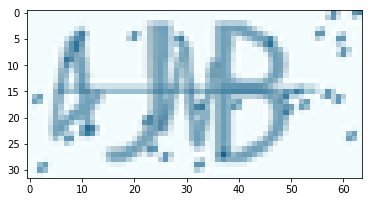

Pred: 4JNB  True:  4JNB


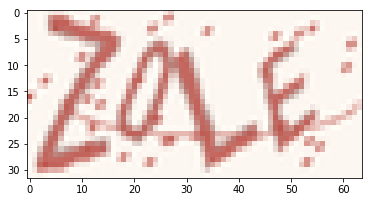

Pred: Z0LE  True:  Z0LE


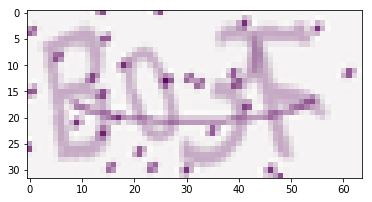

Pred: B03F  True:  B03F


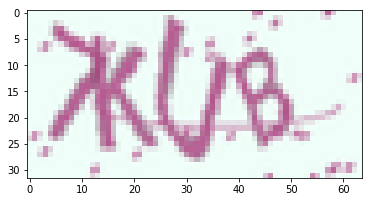

Pred: 7KUB  True:  7KUB


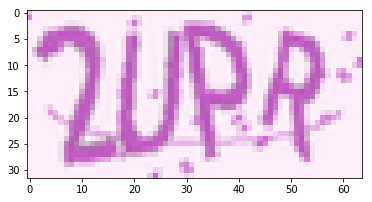

Pred: 2UPR  True:  2UPR


In [103]:
test_image = 400
test_example_one_hot = np.empty((len(test_labels[test_image:test_image+5]),4,36),dtype = object)
for idx,array in enumerate(tqdm(test_labels[test_image:test_image+5])):
    output = one_hot_36_keras(array)
    test_example_one_hot[idx] = output
    del output
my_dict = {x: test_all[test_image:test_image+5],
          y_true: test_example_one_hot
         }
test_pred = session.run(y_pred_cls,feed_dict = my_dict)

for i in range(5):
    testing = misc.imread(testlist[test_image+i])
    plt.imshow(testing)
    plt.show()
    p = test_pred[i]
    prediction = [alphabet[p[0]],alphabet[p[1]],alphabet[p[2]],alphabet[p[3]]]
    print('Pred: '+''.join(prediction),' True: ',test_labels[test_image+i])

Some parts of code were from https://github.com/Hvass-Labs/TensorFlow-Tutorials. It's a great resource for learning Tensorflow. 